In [1]:
# Conditional-gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


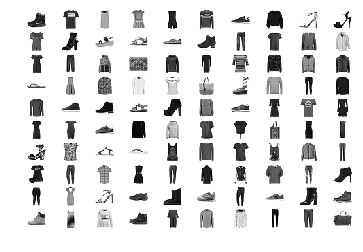

In [2]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# plot images from the training dataset
for i in range(100):
    # define subplot
    pyplot.subplot(10, 10, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [3]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

W0927 05:06:58.523859 4488816064 deprecation_wrapper.py:119] From /Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 05:06:58.547710 4488816064 deprecation_wrapper.py:119] From /Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 05:06:58.549972 4488816064 deprecation_wrapper.py:119] From /Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 05:06:58.610517 4488816064 deprecation_wrapper.py:119] From /Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The n

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 

In [4]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_l

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [10]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
        # generate 'fake' examples
        [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
        # prepare points in latent space as input for the generator
        [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, d_loss1, d_loss2, g_loss))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 5) == 0:
            summarize_performance(i, g_model, latent_dim)

In [12]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1=0.700, d2=0.694 g=0.693


/Users/avinaku5/Anaconda/anaconda3/envs/newenvt/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2, d1=0.640, d2=0.697 g=0.690
>3, d1=0.582, d2=0.701 g=0.687
>4, d1=0.527, d2=0.706 g=0.683
>5, d1=0.475, d2=0.713 g=0.678
>6, d1=0.417, d2=0.725 g=0.669
>7, d1=0.377, d2=0.744 g=0.657
>8, d1=0.330, d2=0.767 g=0.641
>9, d1=0.310, d2=0.795 g=0.631
>10, d1=0.283, d2=0.817 g=0.629
>11, d1=0.264, d2=0.799 g=0.660
>12, d1=0.263, d2=0.761 g=0.713
>13, d1=0.274, d2=0.680 g=0.791
>14, d1=0.335, d2=0.620 g=0.858
>15, d1=0.297, d2=0.587 g=0.891
>16, d1=0.327, d2=0.591 g=0.859
>17, d1=0.353, d2=0.635 g=0.801
>18, d1=0.273, d2=0.671 g=0.768
>19, d1=0.307, d2=0.695 g=0.749
>20, d1=0.278, d2=0.699 g=0.759
>21, d1=0.172, d2=0.701 g=0.755
>22, d1=0.220, d2=0.738 g=0.730
>23, d1=0.213, d2=0.815 g=0.681
>24, d1=0.163, d2=0.890 g=0.651
>25, d1=0.168, d2=0.889 g=0.663
>26, d1=0.139, d2=0.780 g=0.809
>27, d1=0.138, d2=0.581 g=1.065
>28, d1=0.124, d2=0.428 g=1.271
>29, d1=0.111, d2=0.395 g=1.259
>30, d1=0.096, d2=0.458 g=1.087
>31, d1=0.090, d2=0.564 g=0.911
>32, d1=0.090, d2=0.653 g=0.787
>33, d1=0.116, d

>254, d1=0.720, d2=0.649 g=0.827
>255, d1=0.730, d2=0.622 g=0.846
>256, d1=0.730, d2=0.640 g=0.847
>257, d1=0.688, d2=0.671 g=0.859
>258, d1=0.741, d2=0.635 g=0.843
>259, d1=0.744, d2=0.615 g=0.815
>260, d1=0.752, d2=0.681 g=0.773
>261, d1=0.728, d2=0.694 g=0.760
>262, d1=0.723, d2=0.741 g=0.738
>263, d1=0.718, d2=0.721 g=0.735
>264, d1=0.721, d2=0.755 g=0.712
>265, d1=0.764, d2=0.750 g=0.715
>266, d1=0.719, d2=0.713 g=0.731
>267, d1=0.748, d2=0.700 g=0.781
>268, d1=0.723, d2=0.674 g=0.802
>269, d1=0.737, d2=0.678 g=0.819
>270, d1=0.749, d2=0.675 g=0.843
>271, d1=0.752, d2=0.625 g=0.864
>272, d1=0.753, d2=0.611 g=0.848
>273, d1=0.741, d2=0.645 g=0.843
>274, d1=0.730, d2=0.638 g=0.820
>275, d1=0.719, d2=0.673 g=0.806
>276, d1=0.715, d2=0.679 g=0.766
>277, d1=0.744, d2=0.734 g=0.731
>278, d1=0.728, d2=0.702 g=0.723
>279, d1=0.710, d2=0.732 g=0.723
>280, d1=0.737, d2=0.719 g=0.740
>281, d1=0.721, d2=0.687 g=0.752
>282, d1=0.764, d2=0.683 g=0.764
>283, d1=0.741, d2=0.686 g=0.777
>284, d1=0

>503, d1=0.664, d2=0.700 g=0.709
>504, d1=0.652, d2=0.699 g=0.724
>505, d1=0.676, d2=0.704 g=0.728
>506, d1=0.677, d2=0.706 g=0.734
>507, d1=0.674, d2=0.692 g=0.733
>508, d1=0.674, d2=0.692 g=0.727
>509, d1=0.689, d2=0.715 g=0.740
>510, d1=0.682, d2=0.700 g=0.739
>511, d1=0.691, d2=0.684 g=0.740
>512, d1=0.706, d2=0.704 g=0.725
>513, d1=0.705, d2=0.694 g=0.731
>514, d1=0.690, d2=0.703 g=0.751
>515, d1=0.709, d2=0.686 g=0.733
>516, d1=0.702, d2=0.695 g=0.752
>517, d1=0.695, d2=0.667 g=0.743
>518, d1=0.689, d2=0.684 g=0.772
>519, d1=0.700, d2=0.695 g=0.775
>520, d1=0.687, d2=0.655 g=0.769
>521, d1=0.695, d2=0.688 g=0.765
>522, d1=0.704, d2=0.659 g=0.751
>523, d1=0.683, d2=0.653 g=0.750
>524, d1=0.675, d2=0.685 g=0.751
>525, d1=0.662, d2=0.657 g=0.755
>526, d1=0.684, d2=0.683 g=0.768
>527, d1=0.677, d2=0.674 g=0.752
>528, d1=0.709, d2=0.701 g=0.757
>529, d1=0.694, d2=0.680 g=0.765
>530, d1=0.693, d2=0.680 g=0.760
>531, d1=0.714, d2=0.669 g=0.774
>532, d1=0.690, d2=0.659 g=0.775
>533, d1=0

>752, d1=0.634, d2=0.670 g=0.788
>753, d1=0.642, d2=0.632 g=0.801
>754, d1=0.671, d2=0.654 g=0.779
>755, d1=0.647, d2=0.681 g=0.756
>756, d1=0.641, d2=0.658 g=0.753
>757, d1=0.666, d2=0.709 g=0.747
>758, d1=0.643, d2=0.710 g=0.747
>759, d1=0.630, d2=0.687 g=0.751
>760, d1=0.657, d2=0.689 g=0.733
>761, d1=0.650, d2=0.697 g=0.750
>762, d1=0.657, d2=0.678 g=0.757
>763, d1=0.686, d2=0.658 g=0.744
>764, d1=0.672, d2=0.677 g=0.752
>765, d1=0.678, d2=0.668 g=0.770
>766, d1=0.651, d2=0.663 g=0.763
>767, d1=0.654, d2=0.666 g=0.787
>768, d1=0.667, d2=0.665 g=0.793
>769, d1=0.674, d2=0.632 g=0.796
>770, d1=0.646, d2=0.673 g=0.791
>771, d1=0.678, d2=0.636 g=0.784
>772, d1=0.654, d2=0.658 g=0.772
>773, d1=0.628, d2=0.667 g=0.775
>774, d1=0.613, d2=0.674 g=0.755
>775, d1=0.637, d2=0.685 g=0.770
>776, d1=0.627, d2=0.643 g=0.766
>777, d1=0.619, d2=0.632 g=0.756
>778, d1=0.623, d2=0.684 g=0.748
>779, d1=0.622, d2=0.645 g=0.757
>780, d1=0.656, d2=0.656 g=0.768
>781, d1=0.601, d2=0.659 g=0.774
>782, d1=0

>1001, d1=0.716, d2=0.687 g=0.738
>1002, d1=0.738, d2=0.708 g=0.706
>1003, d1=0.745, d2=0.732 g=0.724
>1004, d1=0.710, d2=0.734 g=0.716
>1005, d1=0.727, d2=0.719 g=0.725
>1006, d1=0.718, d2=0.697 g=0.755
>1007, d1=0.729, d2=0.697 g=0.764
>1008, d1=0.756, d2=0.650 g=0.766
>1009, d1=0.690, d2=0.658 g=0.794
>1010, d1=0.678, d2=0.665 g=0.787
>1011, d1=0.693, d2=0.646 g=0.808
>1012, d1=0.698, d2=0.655 g=0.778
>1013, d1=0.712, d2=0.680 g=0.809
>1014, d1=0.736, d2=0.661 g=0.781
>1015, d1=0.675, d2=0.664 g=0.779
>1016, d1=0.668, d2=0.652 g=0.789
>1017, d1=0.679, d2=0.653 g=0.799
>1018, d1=0.687, d2=0.650 g=0.822
>1019, d1=0.678, d2=0.621 g=0.845
>1020, d1=0.634, d2=0.618 g=0.851
>1021, d1=0.688, d2=0.611 g=0.864
>1022, d1=0.678, d2=0.590 g=0.864
>1023, d1=0.671, d2=0.640 g=0.846
>1024, d1=0.677, d2=0.615 g=0.823
>1025, d1=0.666, d2=0.627 g=0.807
>1026, d1=0.695, d2=0.650 g=0.782
>1027, d1=0.664, d2=0.671 g=0.769
>1028, d1=0.669, d2=0.678 g=0.762
>1029, d1=0.662, d2=0.688 g=0.760
>1030, d1=0.66

>1242, d1=0.634, d2=0.602 g=0.816
>1243, d1=0.657, d2=0.621 g=0.821
>1244, d1=0.623, d2=0.633 g=0.835
>1245, d1=0.686, d2=0.615 g=0.825
>1246, d1=0.619, d2=0.608 g=0.829
>1247, d1=0.651, d2=0.630 g=0.828
>1248, d1=0.647, d2=0.619 g=0.808
>1249, d1=0.640, d2=0.657 g=0.802
>1250, d1=0.637, d2=0.644 g=0.829
>1251, d1=0.592, d2=0.654 g=0.797
>1252, d1=0.647, d2=0.660 g=0.773
>1253, d1=0.611, d2=0.657 g=0.809
>1254, d1=0.664, d2=0.658 g=0.816
>1255, d1=0.671, d2=0.628 g=0.807
>1256, d1=0.644, d2=0.638 g=0.816
>1257, d1=0.654, d2=0.644 g=0.813
>1258, d1=0.666, d2=0.625 g=0.826
>1259, d1=0.690, d2=0.640 g=0.832
>1260, d1=0.657, d2=0.605 g=0.860
>1261, d1=0.697, d2=0.589 g=0.826
>1262, d1=0.673, d2=0.615 g=0.870
>1263, d1=0.673, d2=0.603 g=0.854
>1264, d1=0.651, d2=0.628 g=0.819
>1265, d1=0.676, d2=0.639 g=0.817
>1266, d1=0.653, d2=0.621 g=0.823
>1267, d1=0.642, d2=0.613 g=0.802
>1268, d1=0.630, d2=0.635 g=0.806
>1269, d1=0.640, d2=0.645 g=0.805
>1270, d1=0.643, d2=0.663 g=0.832
>1271, d1=0.63

>1483, d1=0.680, d2=0.594 g=0.845
>1484, d1=0.691, d2=0.620 g=0.831
>1485, d1=0.702, d2=0.621 g=0.852
>1486, d1=0.699, d2=0.636 g=0.811
>1487, d1=0.709, d2=0.641 g=0.800
>1488, d1=0.679, d2=0.658 g=0.774
>1489, d1=0.700, d2=0.640 g=0.800
>1490, d1=0.674, d2=0.650 g=0.777
>1491, d1=0.659, d2=0.664 g=0.791
>1492, d1=0.650, d2=0.650 g=0.792
>1493, d1=0.644, d2=0.665 g=0.779
>1494, d1=0.680, d2=0.717 g=0.762
>1495, d1=0.646, d2=0.702 g=0.766
>1496, d1=0.687, d2=0.664 g=0.790
>1497, d1=0.652, d2=0.678 g=0.774
>1498, d1=0.664, d2=0.662 g=0.767
>1499, d1=0.675, d2=0.664 g=0.771
>1500, d1=0.667, d2=0.684 g=0.779
>1501, d1=0.660, d2=0.665 g=0.805
>1502, d1=0.672, d2=0.652 g=0.809
>1503, d1=0.682, d2=0.638 g=0.802
>1504, d1=0.700, d2=0.663 g=0.785
>1505, d1=0.685, d2=0.662 g=0.777
>1506, d1=0.691, d2=0.677 g=0.769
>1507, d1=0.655, d2=0.671 g=0.769
>1508, d1=0.652, d2=0.674 g=0.766
>1509, d1=0.656, d2=0.659 g=0.775
>1510, d1=0.652, d2=0.657 g=0.800
>1511, d1=0.641, d2=0.656 g=0.786
>1512, d1=0.67

>1724, d1=0.638, d2=0.745 g=0.753
>1725, d1=0.688, d2=0.723 g=0.752
>1726, d1=0.662, d2=0.664 g=0.835
>1727, d1=0.682, d2=0.606 g=0.870
>1728, d1=0.715, d2=0.582 g=0.897
>1729, d1=0.716, d2=0.591 g=0.889
>1730, d1=0.714, d2=0.611 g=0.820
>1731, d1=0.721, d2=0.646 g=0.837
>1732, d1=0.731, d2=0.688 g=0.780
>1733, d1=0.682, d2=0.677 g=0.732
>1734, d1=0.687, d2=0.699 g=0.760
>1735, d1=0.677, d2=0.673 g=0.779
>1736, d1=0.651, d2=0.646 g=0.799
>1737, d1=0.658, d2=0.624 g=0.805
>1738, d1=0.645, d2=0.618 g=0.821
>1739, d1=0.626, d2=0.630 g=0.803
>1740, d1=0.632, d2=0.674 g=0.778
>1741, d1=0.667, d2=0.692 g=0.784
>1742, d1=0.691, d2=0.733 g=0.727
>1743, d1=0.653, d2=0.718 g=0.723
>1744, d1=0.662, d2=0.662 g=0.784
>1745, d1=0.663, d2=0.651 g=0.804
>1746, d1=0.675, d2=0.633 g=0.819
>1747, d1=0.653, d2=0.634 g=0.832
>1748, d1=0.701, d2=0.613 g=0.859
>1749, d1=0.708, d2=0.628 g=0.816
>1750, d1=0.681, d2=0.652 g=0.830
>1751, d1=0.676, d2=0.655 g=0.788
>1752, d1=0.700, d2=0.687 g=0.750
>1753, d1=0.66

>1965, d1=0.665, d2=0.652 g=0.776
>1966, d1=0.675, d2=0.650 g=0.763
>1967, d1=0.677, d2=0.677 g=0.792
>1968, d1=0.683, d2=0.657 g=0.771
>1969, d1=0.665, d2=0.661 g=0.776
>1970, d1=0.675, d2=0.653 g=0.767
>1971, d1=0.690, d2=0.696 g=0.765
>1972, d1=0.671, d2=0.656 g=0.766
>1973, d1=0.667, d2=0.650 g=0.780
>1974, d1=0.669, d2=0.652 g=0.776
>1975, d1=0.663, d2=0.631 g=0.789
>1976, d1=0.645, d2=0.644 g=0.757
>1977, d1=0.605, d2=0.670 g=0.748
>1978, d1=0.636, d2=0.693 g=0.755
>1979, d1=0.643, d2=0.726 g=0.738
>1980, d1=0.638, d2=0.693 g=0.775
>1981, d1=0.663, d2=0.675 g=0.773
>1982, d1=0.698, d2=0.619 g=0.804
>1983, d1=0.649, d2=0.640 g=0.786
>1984, d1=0.650, d2=0.641 g=0.812
>1985, d1=0.679, d2=0.660 g=0.831
>1986, d1=0.691, d2=0.620 g=0.833
>1987, d1=0.697, d2=0.622 g=0.788
>1988, d1=0.683, d2=0.648 g=0.779
>1989, d1=0.663, d2=0.646 g=0.780
>1990, d1=0.689, d2=0.638 g=0.794
>1991, d1=0.672, d2=0.639 g=0.785
>1992, d1=0.669, d2=0.662 g=0.805
>1993, d1=0.709, d2=0.611 g=0.806
>1994, d1=0.67

>2206, d1=0.646, d2=0.633 g=0.816
>2207, d1=0.676, d2=0.617 g=0.851
>2208, d1=0.674, d2=0.595 g=0.866
>2209, d1=0.659, d2=0.595 g=0.871
>2210, d1=0.653, d2=0.620 g=0.889
>2211, d1=0.716, d2=0.661 g=0.823
>2212, d1=0.683, d2=0.621 g=0.790
>2213, d1=0.651, d2=0.672 g=0.765
>2214, d1=0.661, d2=0.673 g=0.750
>2215, d1=0.691, d2=0.657 g=0.782
>2216, d1=0.643, d2=0.647 g=0.841
>2217, d1=0.663, d2=0.626 g=0.884
>2218, d1=0.611, d2=0.568 g=0.910
>2219, d1=0.644, d2=0.611 g=0.881
>2220, d1=0.676, d2=0.675 g=0.823
>2221, d1=0.628, d2=0.744 g=0.770
>2222, d1=0.635, d2=0.719 g=0.730
>2223, d1=0.632, d2=0.734 g=0.749
>2224, d1=0.684, d2=0.690 g=0.802
>2225, d1=0.671, d2=0.628 g=0.845
>2226, d1=0.659, d2=0.627 g=0.871
>2227, d1=0.673, d2=0.564 g=0.876
>2228, d1=0.632, d2=0.553 g=0.887
>2229, d1=0.676, d2=0.616 g=0.843
>2230, d1=0.708, d2=0.689 g=0.792
>2231, d1=0.670, d2=0.708 g=0.727
>2232, d1=0.675, d2=0.719 g=0.742
>2233, d1=0.682, d2=0.665 g=0.770
>2234, d1=0.651, d2=0.661 g=0.793
>2235, d1=0.65

>2446, d1=0.693, d2=0.631 g=0.791
>2447, d1=0.655, d2=0.658 g=0.769
>2448, d1=0.683, d2=0.664 g=0.775
>2449, d1=0.679, d2=0.655 g=0.768
>2450, d1=0.680, d2=0.654 g=0.783
>2451, d1=0.684, d2=0.655 g=0.788
>2452, d1=0.664, d2=0.636 g=0.776
>2453, d1=0.656, d2=0.665 g=0.773
>2454, d1=0.666, d2=0.669 g=0.778
>2455, d1=0.700, d2=0.650 g=0.776
>2456, d1=0.687, d2=0.640 g=0.799
>2457, d1=0.667, d2=0.644 g=0.773
>2458, d1=0.681, d2=0.683 g=0.765
>2459, d1=0.733, d2=0.665 g=0.759
>2460, d1=0.646, d2=0.679 g=0.769
>2461, d1=0.657, d2=0.659 g=0.759
>2462, d1=0.654, d2=0.670 g=0.771
>2463, d1=0.680, d2=0.663 g=0.758
>2464, d1=0.676, d2=0.649 g=0.765
>2465, d1=0.675, d2=0.668 g=0.783
>2466, d1=0.693, d2=0.648 g=0.772
>2467, d1=0.649, d2=0.663 g=0.771
>2468, d1=0.687, d2=0.640 g=0.769
>2469, d1=0.678, d2=0.668 g=0.757
>2470, d1=0.678, d2=0.684 g=0.768
>2471, d1=0.703, d2=0.653 g=0.756
>2472, d1=0.660, d2=0.677 g=0.768
>2473, d1=0.659, d2=0.687 g=0.790
>2474, d1=0.707, d2=0.669 g=0.765
>2475, d1=0.64

>2687, d1=0.727, d2=0.643 g=0.812
>2688, d1=0.703, d2=0.666 g=0.762
>2689, d1=0.692, d2=0.659 g=0.786
>2690, d1=0.685, d2=0.720 g=0.749
>2691, d1=0.651, d2=0.680 g=0.764
>2692, d1=0.671, d2=0.672 g=0.755
>2693, d1=0.680, d2=0.643 g=0.763
>2694, d1=0.656, d2=0.658 g=0.796
>2695, d1=0.665, d2=0.680 g=0.767
>2696, d1=0.671, d2=0.697 g=0.775
>2697, d1=0.661, d2=0.656 g=0.738
>2698, d1=0.670, d2=0.688 g=0.733
>2699, d1=0.654, d2=0.696 g=0.734
>2700, d1=0.670, d2=0.670 g=0.769
>2701, d1=0.661, d2=0.679 g=0.783
>2702, d1=0.690, d2=0.630 g=0.813
>2703, d1=0.661, d2=0.610 g=0.838
>2704, d1=0.655, d2=0.627 g=0.815
>2705, d1=0.692, d2=0.623 g=0.824
>2706, d1=0.687, d2=0.664 g=0.776
>2707, d1=0.670, d2=0.659 g=0.761
>2708, d1=0.644, d2=0.692 g=0.769
>2709, d1=0.684, d2=0.674 g=0.770
>2710, d1=0.668, d2=0.663 g=0.773
>2711, d1=0.689, d2=0.659 g=0.792
>2712, d1=0.686, d2=0.605 g=0.836
>2713, d1=0.668, d2=0.636 g=0.816
>2714, d1=0.668, d2=0.646 g=0.793
>2715, d1=0.721, d2=0.666 g=0.778
>2716, d1=0.65

>2928, d1=0.676, d2=0.682 g=0.758
>2929, d1=0.681, d2=0.669 g=0.757
>2930, d1=0.664, d2=0.659 g=0.755
>2931, d1=0.659, d2=0.662 g=0.794
>2932, d1=0.654, d2=0.626 g=0.773
>2933, d1=0.695, d2=0.667 g=0.768
>2934, d1=0.674, d2=0.664 g=0.754
>2935, d1=0.668, d2=0.690 g=0.735
>2936, d1=0.655, d2=0.737 g=0.740
>2937, d1=0.665, d2=0.665 g=0.744
>2938, d1=0.659, d2=0.703 g=0.763
>2939, d1=0.645, d2=0.661 g=0.793
>2940, d1=0.642, d2=0.615 g=0.809
>2941, d1=0.642, d2=0.656 g=0.820
>2942, d1=0.668, d2=0.613 g=0.787
>2943, d1=0.693, d2=0.684 g=0.754
>2944, d1=0.669, d2=0.707 g=0.749
>2945, d1=0.646, d2=0.698 g=0.770
>2946, d1=0.662, d2=0.634 g=0.810
>2947, d1=0.659, d2=0.643 g=0.822
>2948, d1=0.614, d2=0.613 g=0.814
>2949, d1=0.691, d2=0.720 g=0.753
>2950, d1=0.601, d2=0.699 g=0.722
>2951, d1=0.671, d2=0.716 g=0.711
>2952, d1=0.655, d2=0.721 g=0.727
>2953, d1=0.646, d2=0.695 g=0.748
>2954, d1=0.676, d2=0.650 g=0.778
>2955, d1=0.660, d2=0.628 g=0.812
>2956, d1=0.679, d2=0.643 g=0.789
>2957, d1=0.68

>3169, d1=0.649, d2=0.676 g=0.771
>3170, d1=0.679, d2=0.670 g=0.787
>3171, d1=0.673, d2=0.637 g=0.799
>3172, d1=0.652, d2=0.634 g=0.832
>3173, d1=0.648, d2=0.662 g=0.814
>3174, d1=0.644, d2=0.632 g=0.794
>3175, d1=0.636, d2=0.693 g=0.771
>3176, d1=0.672, d2=0.682 g=0.766
>3177, d1=0.689, d2=0.693 g=0.768
>3178, d1=0.675, d2=0.659 g=0.799
>3179, d1=0.696, d2=0.619 g=0.803
>3180, d1=0.669, d2=0.618 g=0.818
>3181, d1=0.665, d2=0.648 g=0.818
>3182, d1=0.673, d2=0.617 g=0.796
>3183, d1=0.679, d2=0.684 g=0.757
>3184, d1=0.669, d2=0.672 g=0.766
>3185, d1=0.673, d2=0.659 g=0.779
>3186, d1=0.650, d2=0.654 g=0.806
>3187, d1=0.663, d2=0.661 g=0.824
>3188, d1=0.662, d2=0.632 g=0.832
>3189, d1=0.628, d2=0.631 g=0.800
>3190, d1=0.659, d2=0.655 g=0.794
>3191, d1=0.649, d2=0.684 g=0.758
>3192, d1=0.654, d2=0.688 g=0.745
>3193, d1=0.670, d2=0.679 g=0.747
>3194, d1=0.687, d2=0.691 g=0.790
>3195, d1=0.670, d2=0.645 g=0.804
>3196, d1=0.652, d2=0.621 g=0.865
>3197, d1=0.674, d2=0.623 g=0.871
>3198, d1=0.69

>3410, d1=0.671, d2=0.672 g=0.797
>3411, d1=0.653, d2=0.627 g=0.824
>3412, d1=0.669, d2=0.610 g=0.878
>3413, d1=0.676, d2=0.619 g=0.861
>3414, d1=0.718, d2=0.613 g=0.846
>3415, d1=0.683, d2=0.648 g=0.806
>3416, d1=0.651, d2=0.691 g=0.785
>3417, d1=0.678, d2=0.636 g=0.781
>3418, d1=0.639, d2=0.634 g=0.799
>3419, d1=0.687, d2=0.649 g=0.801
>3420, d1=0.660, d2=0.628 g=0.813
>3421, d1=0.631, d2=0.642 g=0.795
>3422, d1=0.685, d2=0.673 g=0.763
>3423, d1=0.648, d2=0.709 g=0.778
>3424, d1=0.646, d2=0.695 g=0.771
>3425, d1=0.646, d2=0.644 g=0.793
>3426, d1=0.665, d2=0.663 g=0.801
>3427, d1=0.660, d2=0.656 g=0.794
>3428, d1=0.661, d2=0.671 g=0.782
>3429, d1=0.655, d2=0.643 g=0.787
>3430, d1=0.670, d2=0.657 g=0.779
>3431, d1=0.637, d2=0.655 g=0.763
>3432, d1=0.633, d2=0.653 g=0.776
>3433, d1=0.642, d2=0.671 g=0.755
>3434, d1=0.666, d2=0.651 g=0.762
>3435, d1=0.652, d2=0.655 g=0.763
>3436, d1=0.651, d2=0.674 g=0.756
>3437, d1=0.655, d2=0.640 g=0.757
>3438, d1=0.670, d2=0.662 g=0.736
>3439, d1=0.63

>3651, d1=0.679, d2=0.647 g=0.793
>3652, d1=0.694, d2=0.648 g=0.805
>3653, d1=0.662, d2=0.627 g=0.824
>3654, d1=0.652, d2=0.655 g=0.806
>3655, d1=0.629, d2=0.660 g=0.764
>3656, d1=0.677, d2=0.709 g=0.751
>3657, d1=0.709, d2=0.720 g=0.765
>3658, d1=0.661, d2=0.635 g=0.796
>3659, d1=0.644, d2=0.627 g=0.827
>3660, d1=0.675, d2=0.631 g=0.835
>3661, d1=0.691, d2=0.599 g=0.786
>3662, d1=0.662, d2=0.666 g=0.795
>3663, d1=0.654, d2=0.695 g=0.754
>3664, d1=0.645, d2=0.701 g=0.764
>3665, d1=0.663, d2=0.666 g=0.780
>3666, d1=0.642, d2=0.639 g=0.825
>3667, d1=0.683, d2=0.613 g=0.815
>3668, d1=0.657, d2=0.627 g=0.783
>3669, d1=0.644, d2=0.682 g=0.761
>3670, d1=0.684, d2=0.691 g=0.771
>3671, d1=0.679, d2=0.664 g=0.781
>3672, d1=0.644, d2=0.655 g=0.800
>3673, d1=0.674, d2=0.660 g=0.819
>3674, d1=0.685, d2=0.637 g=0.813
>3675, d1=0.713, d2=0.627 g=0.789
>3676, d1=0.689, d2=0.642 g=0.787
>3677, d1=0.671, d2=0.639 g=0.794
>3678, d1=0.682, d2=0.622 g=0.789
>3679, d1=0.657, d2=0.690 g=0.778
>3680, d1=0.66

>3892, d1=0.677, d2=0.664 g=0.788
>3893, d1=0.695, d2=0.659 g=0.774
>3894, d1=0.674, d2=0.648 g=0.793
>3895, d1=0.684, d2=0.628 g=0.797
>3896, d1=0.648, d2=0.684 g=0.786
>3897, d1=0.652, d2=0.659 g=0.784
>3898, d1=0.665, d2=0.680 g=0.778
>3899, d1=0.672, d2=0.643 g=0.770
>3900, d1=0.658, d2=0.653 g=0.789
>3901, d1=0.629, d2=0.620 g=0.819
>3902, d1=0.689, d2=0.676 g=0.783
>3903, d1=0.675, d2=0.679 g=0.788
>3904, d1=0.647, d2=0.668 g=0.778
>3905, d1=0.668, d2=0.666 g=0.780
>3906, d1=0.656, d2=0.633 g=0.799
>3907, d1=0.635, d2=0.653 g=0.814
>3908, d1=0.685, d2=0.670 g=0.810
>3909, d1=0.677, d2=0.659 g=0.758
>3910, d1=0.674, d2=0.705 g=0.760
>3911, d1=0.672, d2=0.678 g=0.780
>3912, d1=0.687, d2=0.671 g=0.797
>3913, d1=0.608, d2=0.671 g=0.787
>3914, d1=0.661, d2=0.645 g=0.789
>3915, d1=0.650, d2=0.675 g=0.775
>3916, d1=0.656, d2=0.655 g=0.752
>3917, d1=0.638, d2=0.700 g=0.801
>3918, d1=0.681, d2=0.678 g=0.799
>3919, d1=0.683, d2=0.659 g=0.795
>3920, d1=0.682, d2=0.625 g=0.802
>3921, d1=0.68

>4133, d1=0.658, d2=0.675 g=0.762
>4134, d1=0.655, d2=0.686 g=0.787
>4135, d1=0.663, d2=0.660 g=0.782
>4136, d1=0.677, d2=0.662 g=0.794
>4137, d1=0.657, d2=0.627 g=0.786
>4138, d1=0.669, d2=0.644 g=0.789
>4139, d1=0.668, d2=0.654 g=0.785
>4140, d1=0.657, d2=0.642 g=0.786
>4141, d1=0.678, d2=0.668 g=0.765
>4142, d1=0.648, d2=0.708 g=0.760
>4143, d1=0.670, d2=0.677 g=0.763
>4144, d1=0.641, d2=0.672 g=0.775
>4145, d1=0.662, d2=0.670 g=0.786
>4146, d1=0.629, d2=0.668 g=0.756
>4147, d1=0.685, d2=0.703 g=0.769
>4148, d1=0.664, d2=0.665 g=0.775
>4149, d1=0.679, d2=0.698 g=0.806
>4150, d1=0.637, d2=0.647 g=0.808
>4151, d1=0.672, d2=0.645 g=0.778
>4152, d1=0.673, d2=0.652 g=0.799
>4153, d1=0.675, d2=0.653 g=0.751
>4154, d1=0.692, d2=0.650 g=0.761
>4155, d1=0.663, d2=0.696 g=0.788
>4156, d1=0.649, d2=0.668 g=0.761
>4157, d1=0.659, d2=0.654 g=0.765
>4158, d1=0.666, d2=0.666 g=0.779
>4159, d1=0.648, d2=0.649 g=0.790
>4160, d1=0.689, d2=0.668 g=0.755
>4161, d1=0.647, d2=0.650 g=0.797
>4162, d1=0.71

>4374, d1=0.658, d2=0.676 g=0.788
>4375, d1=0.702, d2=0.630 g=0.781
>4376, d1=0.708, d2=0.648 g=0.819
>4377, d1=0.673, d2=0.632 g=0.828
>4378, d1=0.704, d2=0.655 g=0.817
>4379, d1=0.702, d2=0.644 g=0.782
>4380, d1=0.701, d2=0.669 g=0.774
>4381, d1=0.654, d2=0.676 g=0.762
>4382, d1=0.666, d2=0.673 g=0.786
>4383, d1=0.694, d2=0.644 g=0.772
>4384, d1=0.671, d2=0.681 g=0.784
>4385, d1=0.657, d2=0.693 g=0.774
>4386, d1=0.653, d2=0.685 g=0.801
>4387, d1=0.646, d2=0.646 g=0.776
>4388, d1=0.680, d2=0.668 g=0.794
>4389, d1=0.678, d2=0.635 g=0.799
>4390, d1=0.667, d2=0.661 g=0.811
>4391, d1=0.672, d2=0.665 g=0.763
>4392, d1=0.692, d2=0.684 g=0.782
>4393, d1=0.653, d2=0.670 g=0.799
>4394, d1=0.683, d2=0.652 g=0.815
>4395, d1=0.667, d2=0.667 g=0.800
>4396, d1=0.661, d2=0.664 g=0.796
>4397, d1=0.641, d2=0.676 g=0.764
>4398, d1=0.690, d2=0.698 g=0.783
>4399, d1=0.658, d2=0.680 g=0.793
>4400, d1=0.666, d2=0.637 g=0.770
>4401, d1=0.710, d2=0.705 g=0.771
>4402, d1=0.644, d2=0.688 g=0.761
>4403, d1=0.63

>4615, d1=0.695, d2=0.685 g=0.796
>4616, d1=0.661, d2=0.679 g=0.786
>4617, d1=0.660, d2=0.635 g=0.773
>4618, d1=0.659, d2=0.648 g=0.768
>4619, d1=0.662, d2=0.683 g=0.777
>4620, d1=0.643, d2=0.636 g=0.754
>4621, d1=0.672, d2=0.640 g=0.785
>4622, d1=0.658, d2=0.652 g=0.762
>4623, d1=0.694, d2=0.664 g=0.784
>4624, d1=0.663, d2=0.710 g=0.738
>4625, d1=0.692, d2=0.678 g=0.769
>4626, d1=0.652, d2=0.683 g=0.759
>4627, d1=0.632, d2=0.672 g=0.755
>4628, d1=0.617, d2=0.662 g=0.782
>4629, d1=0.671, d2=0.676 g=0.767
>4630, d1=0.664, d2=0.670 g=0.759
>4631, d1=0.672, d2=0.675 g=0.766
>4632, d1=0.691, d2=0.656 g=0.797
>4633, d1=0.636, d2=0.631 g=0.804
>4634, d1=0.680, d2=0.629 g=0.794
>4635, d1=0.700, d2=0.655 g=0.812
>4636, d1=0.657, d2=0.682 g=0.787
>4637, d1=0.634, d2=0.680 g=0.743
>4638, d1=0.685, d2=0.697 g=0.758
>4639, d1=0.653, d2=0.691 g=0.810
>4640, d1=0.648, d2=0.645 g=0.841
>4641, d1=0.676, d2=0.637 g=0.797
>4642, d1=0.662, d2=0.690 g=0.770
>4643, d1=0.682, d2=0.717 g=0.768
>4644, d1=0.65

>4855, d1=0.681, d2=0.650 g=0.853
>4856, d1=0.686, d2=0.642 g=0.842
>4857, d1=0.663, d2=0.643 g=0.792
>4858, d1=0.650, d2=0.664 g=0.768
>4859, d1=0.684, d2=0.648 g=0.735
>4860, d1=0.660, d2=0.670 g=0.785
>4861, d1=0.657, d2=0.651 g=0.815
>4862, d1=0.669, d2=0.666 g=0.779
>4863, d1=0.643, d2=0.692 g=0.764
>4864, d1=0.690, d2=0.685 g=0.760
>4865, d1=0.667, d2=0.681 g=0.768
>4866, d1=0.661, d2=0.659 g=0.818
>4867, d1=0.650, d2=0.628 g=0.815
>4868, d1=0.685, d2=0.618 g=0.820
>4869, d1=0.705, d2=0.669 g=0.806
>4870, d1=0.668, d2=0.669 g=0.779
>4871, d1=0.707, d2=0.673 g=0.798
>4872, d1=0.689, d2=0.668 g=0.783
>4873, d1=0.646, d2=0.656 g=0.778
>4874, d1=0.649, d2=0.639 g=0.761
>4875, d1=0.657, d2=0.671 g=0.780
>4876, d1=0.643, d2=0.658 g=0.794
>4877, d1=0.675, d2=0.669 g=0.816
>4878, d1=0.671, d2=0.626 g=0.821
>4879, d1=0.671, d2=0.647 g=0.809
>4880, d1=0.714, d2=0.678 g=0.782
>4881, d1=0.684, d2=0.663 g=0.793
>4882, d1=0.681, d2=0.665 g=0.786
>4883, d1=0.643, d2=0.673 g=0.797
>4884, d1=0.65

>5096, d1=0.703, d2=0.649 g=0.796
>5097, d1=0.653, d2=0.658 g=0.786
>5098, d1=0.715, d2=0.627 g=0.802
>5099, d1=0.647, d2=0.665 g=0.803
>5100, d1=0.654, d2=0.695 g=0.794
>5101, d1=0.688, d2=0.656 g=0.760
>5102, d1=0.684, d2=0.646 g=0.820
>5103, d1=0.664, d2=0.664 g=0.810
>5104, d1=0.655, d2=0.626 g=0.770
>5105, d1=0.703, d2=0.686 g=0.793
>5106, d1=0.709, d2=0.703 g=0.793
>5107, d1=0.668, d2=0.639 g=0.823
>5108, d1=0.621, d2=0.634 g=0.815
>5109, d1=0.664, d2=0.713 g=0.783
>5110, d1=0.694, d2=0.723 g=0.789
>5111, d1=0.649, d2=0.670 g=0.844
>5112, d1=0.671, d2=0.641 g=0.881
>5113, d1=0.711, d2=0.628 g=0.845
>5114, d1=0.688, d2=0.649 g=0.805
>5115, d1=0.690, d2=0.646 g=0.804
>5116, d1=0.670, d2=0.649 g=0.773
>5117, d1=0.690, d2=0.654 g=0.762
>5118, d1=0.674, d2=0.654 g=0.780
>5119, d1=0.635, d2=0.696 g=0.760
>5120, d1=0.646, d2=0.692 g=0.744
>5121, d1=0.646, d2=0.675 g=0.765
>5122, d1=0.623, d2=0.652 g=0.807
>5123, d1=0.703, d2=0.661 g=0.789
>5124, d1=0.659, d2=0.651 g=0.799
>5125, d1=0.70

>5337, d1=0.677, d2=0.669 g=0.804
>5338, d1=0.684, d2=0.645 g=0.819
>5339, d1=0.688, d2=0.681 g=0.786
>5340, d1=0.654, d2=0.648 g=0.755
>5341, d1=0.624, d2=0.675 g=0.764
>5342, d1=0.665, d2=0.672 g=0.781
>5343, d1=0.667, d2=0.679 g=0.781
>5344, d1=0.649, d2=0.651 g=0.773
>5345, d1=0.631, d2=0.655 g=0.772
>5346, d1=0.645, d2=0.665 g=0.783
>5347, d1=0.665, d2=0.664 g=0.754
>5348, d1=0.693, d2=0.662 g=0.809
>5349, d1=0.655, d2=0.664 g=0.765
>5350, d1=0.623, d2=0.694 g=0.756
>5351, d1=0.704, d2=0.661 g=0.781
>5352, d1=0.679, d2=0.679 g=0.743
>5353, d1=0.676, d2=0.694 g=0.773
>5354, d1=0.657, d2=0.663 g=0.773
>5355, d1=0.700, d2=0.660 g=0.777
>5356, d1=0.659, d2=0.653 g=0.776
>5357, d1=0.687, d2=0.642 g=0.786
>5358, d1=0.642, d2=0.632 g=0.782
>5359, d1=0.629, d2=0.659 g=0.780
>5360, d1=0.664, d2=0.669 g=0.769
>5361, d1=0.681, d2=0.676 g=0.770
>5362, d1=0.622, d2=0.680 g=0.788
>5363, d1=0.662, d2=0.630 g=0.771
>5364, d1=0.693, d2=0.652 g=0.781
>5365, d1=0.690, d2=0.705 g=0.778
>5366, d1=0.66

>5578, d1=0.666, d2=0.655 g=0.784
>5579, d1=0.647, d2=0.658 g=0.765
>5580, d1=0.658, d2=0.672 g=0.796
>5581, d1=0.697, d2=0.685 g=0.761
>5582, d1=0.651, d2=0.663 g=0.785
>5583, d1=0.669, d2=0.674 g=0.785
>5584, d1=0.668, d2=0.654 g=0.763
>5585, d1=0.701, d2=0.623 g=0.759
>5586, d1=0.651, d2=0.610 g=0.756
>5587, d1=0.650, d2=0.684 g=0.775
>5588, d1=0.668, d2=0.674 g=0.747
>5589, d1=0.668, d2=0.659 g=0.781
>5590, d1=0.655, d2=0.709 g=0.748
>5591, d1=0.671, d2=0.658 g=0.782
>5592, d1=0.664, d2=0.672 g=0.781
>5593, d1=0.663, d2=0.659 g=0.806
>5594, d1=0.692, d2=0.648 g=0.780
>5595, d1=0.669, d2=0.680 g=0.809
>5596, d1=0.669, d2=0.659 g=0.791
>5597, d1=0.682, d2=0.648 g=0.753
>5598, d1=0.673, d2=0.696 g=0.790
>5599, d1=0.658, d2=0.666 g=0.786
>5600, d1=0.688, d2=0.670 g=0.797
>5601, d1=0.600, d2=0.657 g=0.780
>5602, d1=0.712, d2=0.673 g=0.764
>5603, d1=0.667, d2=0.719 g=0.788
>5604, d1=0.685, d2=0.653 g=0.857
>5605, d1=0.710, d2=0.632 g=0.834
>5606, d1=0.708, d2=0.643 g=0.797
>5607, d1=0.68

>5819, d1=0.685, d2=0.683 g=0.816
>5820, d1=0.694, d2=0.670 g=0.755
>5821, d1=0.688, d2=0.661 g=0.764
>5822, d1=0.635, d2=0.678 g=0.760
>5823, d1=0.668, d2=0.713 g=0.784
>5824, d1=0.693, d2=0.651 g=0.776
>5825, d1=0.625, d2=0.693 g=0.774
>5826, d1=0.662, d2=0.668 g=0.765
>5827, d1=0.631, d2=0.667 g=0.780
>5828, d1=0.671, d2=0.672 g=0.784
>5829, d1=0.639, d2=0.643 g=0.796
>5830, d1=0.671, d2=0.653 g=0.788
>5831, d1=0.637, d2=0.687 g=0.763
>5832, d1=0.643, d2=0.676 g=0.761
>5833, d1=0.635, d2=0.670 g=0.773
>5834, d1=0.658, d2=0.629 g=0.823
>5835, d1=0.715, d2=0.630 g=0.806
>5836, d1=0.677, d2=0.648 g=0.803
>5837, d1=0.666, d2=0.629 g=0.801
>5838, d1=0.687, d2=0.676 g=0.776
>5839, d1=0.684, d2=0.671 g=0.772
>5840, d1=0.659, d2=0.668 g=0.786
>5841, d1=0.658, d2=0.662 g=0.808
>5842, d1=0.670, d2=0.664 g=0.823
>5843, d1=0.679, d2=0.617 g=0.791
>5844, d1=0.681, d2=0.694 g=0.784
>5845, d1=0.706, d2=0.653 g=0.789
>5846, d1=0.665, d2=0.659 g=0.817
>5847, d1=0.682, d2=0.650 g=0.818
>5848, d1=0.70

>6060, d1=0.654, d2=0.650 g=0.789
>6061, d1=0.629, d2=0.673 g=0.772
>6062, d1=0.671, d2=0.692 g=0.794
>6063, d1=0.660, d2=0.651 g=0.764
>6064, d1=0.682, d2=0.661 g=0.759
>6065, d1=0.669, d2=0.655 g=0.788
>6066, d1=0.691, d2=0.691 g=0.779
>6067, d1=0.653, d2=0.642 g=0.759
>6068, d1=0.672, d2=0.621 g=0.806
>6069, d1=0.653, d2=0.649 g=0.802
>6070, d1=0.661, d2=0.697 g=0.766
>6071, d1=0.630, d2=0.671 g=0.759
>6072, d1=0.675, d2=0.698 g=0.776
>6073, d1=0.648, d2=0.659 g=0.744
>6074, d1=0.661, d2=0.694 g=0.788
>6075, d1=0.652, d2=0.666 g=0.759
>6076, d1=0.654, d2=0.661 g=0.771
>6077, d1=0.662, d2=0.669 g=0.784
>6078, d1=0.678, d2=0.684 g=0.740
>6079, d1=0.649, d2=0.646 g=0.772
>6080, d1=0.633, d2=0.660 g=0.781
>6081, d1=0.681, d2=0.643 g=0.766
>6082, d1=0.679, d2=0.659 g=0.767
>6083, d1=0.653, d2=0.669 g=0.746
>6084, d1=0.698, d2=0.692 g=0.776
>6085, d1=0.684, d2=0.709 g=0.755
>6086, d1=0.685, d2=0.656 g=0.763
>6087, d1=0.619, d2=0.693 g=0.790
>6088, d1=0.701, d2=0.674 g=0.772
>6089, d1=0.65

>6301, d1=0.681, d2=0.641 g=0.773
>6302, d1=0.689, d2=0.644 g=0.760
>6303, d1=0.679, d2=0.652 g=0.775
>6304, d1=0.644, d2=0.666 g=0.774
>6305, d1=0.692, d2=0.692 g=0.777
>6306, d1=0.653, d2=0.632 g=0.759
>6307, d1=0.696, d2=0.682 g=0.768
>6308, d1=0.616, d2=0.691 g=0.769
>6309, d1=0.670, d2=0.671 g=0.791
>6310, d1=0.703, d2=0.676 g=0.763
>6311, d1=0.695, d2=0.690 g=0.763
>6312, d1=0.696, d2=0.676 g=0.784
>6313, d1=0.670, d2=0.647 g=0.786
>6314, d1=0.654, d2=0.656 g=0.784
>6315, d1=0.685, d2=0.679 g=0.783
>6316, d1=0.651, d2=0.666 g=0.792
>6317, d1=0.706, d2=0.678 g=0.765
>6318, d1=0.683, d2=0.634 g=0.779
>6319, d1=0.679, d2=0.671 g=0.785
>6320, d1=0.665, d2=0.719 g=0.777
>6321, d1=0.659, d2=0.677 g=0.767
>6322, d1=0.674, d2=0.669 g=0.770
>6323, d1=0.662, d2=0.654 g=0.795
>6324, d1=0.716, d2=0.676 g=0.758
>6325, d1=0.696, d2=0.654 g=0.796
>6326, d1=0.646, d2=0.646 g=0.791
>6327, d1=0.668, d2=0.680 g=0.787
>6328, d1=0.695, d2=0.678 g=0.781
>6329, d1=0.660, d2=0.654 g=0.792
>6330, d1=0.65

>6542, d1=0.696, d2=0.658 g=0.777
>6543, d1=0.693, d2=0.688 g=0.763
>6544, d1=0.672, d2=0.657 g=0.783
>6545, d1=0.666, d2=0.677 g=0.785
>6546, d1=0.669, d2=0.683 g=0.799
>6547, d1=0.672, d2=0.633 g=0.756
>6548, d1=0.614, d2=0.692 g=0.782
>6549, d1=0.630, d2=0.659 g=0.789
>6550, d1=0.676, d2=0.675 g=0.806
>6551, d1=0.676, d2=0.709 g=0.796
>6552, d1=0.669, d2=0.651 g=0.811
>6553, d1=0.695, d2=0.623 g=0.832
>6554, d1=0.734, d2=0.623 g=0.786
>6555, d1=0.681, d2=0.689 g=0.805
>6556, d1=0.681, d2=0.663 g=0.744
>6557, d1=0.692, d2=0.708 g=0.765
>6558, d1=0.664, d2=0.660 g=0.810
>6559, d1=0.628, d2=0.651 g=0.804
>6560, d1=0.669, d2=0.675 g=0.793
>6561, d1=0.650, d2=0.690 g=0.749
>6562, d1=0.668, d2=0.715 g=0.757
>6563, d1=0.643, d2=0.622 g=0.830
>6564, d1=0.647, d2=0.600 g=0.860
>6565, d1=0.730, d2=0.602 g=0.839
>6566, d1=0.692, d2=0.702 g=0.763
>6567, d1=0.696, d2=0.699 g=0.760
>6568, d1=0.632, d2=0.703 g=0.763
>6569, d1=0.675, d2=0.652 g=0.801
>6570, d1=0.643, d2=0.675 g=0.820
>6571, d1=0.62

>6783, d1=0.707, d2=0.632 g=0.841
>6784, d1=0.683, d2=0.678 g=0.800
>6785, d1=0.671, d2=0.682 g=0.786
>6786, d1=0.695, d2=0.687 g=0.793
>6787, d1=0.669, d2=0.631 g=0.805
>6788, d1=0.677, d2=0.610 g=0.825
>6789, d1=0.670, d2=0.666 g=0.807
>6790, d1=0.664, d2=0.708 g=0.779
>6791, d1=0.665, d2=0.681 g=0.780
>6792, d1=0.670, d2=0.677 g=0.792
>6793, d1=0.677, d2=0.666 g=0.811
>6794, d1=0.694, d2=0.638 g=0.840
>6795, d1=0.690, d2=0.665 g=0.811
>6796, d1=0.675, d2=0.695 g=0.770
>6797, d1=0.668, d2=0.658 g=0.786
>6798, d1=0.664, d2=0.652 g=0.809
>6799, d1=0.674, d2=0.633 g=0.845
>6800, d1=0.659, d2=0.640 g=0.785
>6801, d1=0.709, d2=0.715 g=0.761
>6802, d1=0.664, d2=0.699 g=0.770
>6803, d1=0.711, d2=0.641 g=0.808
>6804, d1=0.667, d2=0.617 g=0.848
>6805, d1=0.681, d2=0.645 g=0.816
>6806, d1=0.645, d2=0.688 g=0.795
>6807, d1=0.653, d2=0.702 g=0.780
>6808, d1=0.649, d2=0.664 g=0.774
>6809, d1=0.658, d2=0.643 g=0.812
>6810, d1=0.676, d2=0.664 g=0.804
>6811, d1=0.710, d2=0.680 g=0.792
>6812, d1=0.65

>7023, d1=0.645, d2=0.646 g=0.779
>7024, d1=0.623, d2=0.658 g=0.776
>7025, d1=0.696, d2=0.628 g=0.794
>7026, d1=0.621, d2=0.691 g=0.773
>7027, d1=0.665, d2=0.684 g=0.769
>7028, d1=0.633, d2=0.666 g=0.780
>7029, d1=0.680, d2=0.652 g=0.778
>7030, d1=0.655, d2=0.679 g=0.772
>7031, d1=0.660, d2=0.668 g=0.772
>7032, d1=0.657, d2=0.639 g=0.780
>7033, d1=0.718, d2=0.663 g=0.791
>7034, d1=0.681, d2=0.684 g=0.779
>7035, d1=0.686, d2=0.660 g=0.755
>7036, d1=0.696, d2=0.637 g=0.759
>7037, d1=0.660, d2=0.656 g=0.767
>7038, d1=0.639, d2=0.674 g=0.771
>7039, d1=0.698, d2=0.680 g=0.802
>7040, d1=0.663, d2=0.651 g=0.791
>7041, d1=0.706, d2=0.661 g=0.786
>7042, d1=0.698, d2=0.669 g=0.782
>7043, d1=0.707, d2=0.684 g=0.775
>7044, d1=0.664, d2=0.651 g=0.741
>7045, d1=0.680, d2=0.647 g=0.782
>7046, d1=0.684, d2=0.709 g=0.772
>7047, d1=0.710, d2=0.663 g=0.746
>7048, d1=0.652, d2=0.694 g=0.754
>7049, d1=0.650, d2=0.664 g=0.807
>7050, d1=0.665, d2=0.659 g=0.803
>7051, d1=0.688, d2=0.685 g=0.807
>7052, d1=0.65

>7264, d1=0.682, d2=0.669 g=0.780
>7265, d1=0.657, d2=0.671 g=0.798
>7266, d1=0.668, d2=0.706 g=0.763
>7267, d1=0.676, d2=0.652 g=0.774
>7268, d1=0.684, d2=0.684 g=0.782
>7269, d1=0.669, d2=0.697 g=0.783
>7270, d1=0.644, d2=0.693 g=0.780
>7271, d1=0.656, d2=0.678 g=0.775
>7272, d1=0.635, d2=0.680 g=0.811
>7273, d1=0.660, d2=0.669 g=0.781
>7274, d1=0.650, d2=0.686 g=0.773
>7275, d1=0.628, d2=0.648 g=0.810
>7276, d1=0.644, d2=0.623 g=0.798
>7277, d1=0.666, d2=0.649 g=0.802
>7278, d1=0.677, d2=0.641 g=0.796
>7279, d1=0.680, d2=0.638 g=0.816
>7280, d1=0.694, d2=0.656 g=0.787
>7281, d1=0.731, d2=0.643 g=0.794
>7282, d1=0.653, d2=0.685 g=0.779
>7283, d1=0.698, d2=0.670 g=0.779
>7284, d1=0.668, d2=0.680 g=0.763
>7285, d1=0.677, d2=0.667 g=0.768
>7286, d1=0.649, d2=0.651 g=0.760
>7287, d1=0.691, d2=0.702 g=0.774
>7288, d1=0.664, d2=0.693 g=0.804
>7289, d1=0.677, d2=0.665 g=0.798
>7290, d1=0.683, d2=0.658 g=0.790
>7291, d1=0.666, d2=0.642 g=0.788
>7292, d1=0.717, d2=0.654 g=0.765
>7293, d1=0.63

>7505, d1=0.680, d2=0.642 g=0.830
>7506, d1=0.682, d2=0.615 g=0.823
>7507, d1=0.656, d2=0.688 g=0.777
>7508, d1=0.671, d2=0.686 g=0.750
>7509, d1=0.654, d2=0.673 g=0.785
>7510, d1=0.660, d2=0.635 g=0.802
>7511, d1=0.680, d2=0.654 g=0.831
>7512, d1=0.666, d2=0.702 g=0.800
>7513, d1=0.657, d2=0.693 g=0.788
>7514, d1=0.645, d2=0.694 g=0.783
>7515, d1=0.643, d2=0.674 g=0.835
>7516, d1=0.679, d2=0.623 g=0.862
>7517, d1=0.706, d2=0.616 g=0.834
>7518, d1=0.680, d2=0.601 g=0.817
>7519, d1=0.663, d2=0.676 g=0.775
>7520, d1=0.638, d2=0.683 g=0.784
>7521, d1=0.653, d2=0.692 g=0.760
>7522, d1=0.692, d2=0.665 g=0.798
>7523, d1=0.680, d2=0.663 g=0.807
>7524, d1=0.669, d2=0.634 g=0.793
>7525, d1=0.660, d2=0.649 g=0.794
>7526, d1=0.662, d2=0.689 g=0.780
>7527, d1=0.673, d2=0.681 g=0.783
>7528, d1=0.656, d2=0.657 g=0.759
>7529, d1=0.642, d2=0.661 g=0.794
>7530, d1=0.673, d2=0.608 g=0.826
>7531, d1=0.704, d2=0.665 g=0.754
>7532, d1=0.685, d2=0.673 g=0.767
>7533, d1=0.674, d2=0.667 g=0.786
>7534, d1=0.64

>7746, d1=0.647, d2=0.620 g=0.829
>7747, d1=0.688, d2=0.686 g=0.830
>7748, d1=0.644, d2=0.652 g=0.785
>7749, d1=0.663, d2=0.700 g=0.772
>7750, d1=0.655, d2=0.632 g=0.835
>7751, d1=0.671, d2=0.638 g=0.852
>7752, d1=0.671, d2=0.557 g=0.915
>7753, d1=0.688, d2=0.624 g=0.853
>7754, d1=0.677, d2=0.606 g=0.801
>7755, d1=0.744, d2=0.714 g=0.756
>7756, d1=0.670, d2=0.696 g=0.792
>7757, d1=0.635, d2=0.624 g=0.858
>7758, d1=0.677, d2=0.663 g=0.882
>7759, d1=0.639, d2=0.659 g=0.817
>7760, d1=0.641, d2=0.681 g=0.760
>7761, d1=0.644, d2=0.669 g=0.773
>7762, d1=0.641, d2=0.723 g=0.790
>7763, d1=0.639, d2=0.688 g=0.846
>7764, d1=0.705, d2=0.597 g=0.842
>7765, d1=0.662, d2=0.624 g=0.870
>7766, d1=0.699, d2=0.608 g=0.800
>7767, d1=0.717, d2=0.617 g=0.807
>7768, d1=0.664, d2=0.701 g=0.748
>7769, d1=0.631, d2=0.708 g=0.791
>7770, d1=0.640, d2=0.673 g=0.796
>7771, d1=0.645, d2=0.636 g=0.825
>7772, d1=0.669, d2=0.695 g=0.837
>7773, d1=0.631, d2=0.684 g=0.767
>7774, d1=0.661, d2=0.707 g=0.767
>7775, d1=0.66

>7987, d1=0.626, d2=0.676 g=0.784
>7988, d1=0.680, d2=0.692 g=0.743
>7989, d1=0.677, d2=0.753 g=0.755
>7990, d1=0.665, d2=0.719 g=0.790
>7991, d1=0.699, d2=0.619 g=0.797
>7992, d1=0.644, d2=0.643 g=0.814
>7993, d1=0.706, d2=0.673 g=0.775
>7994, d1=0.692, d2=0.690 g=0.767
>7995, d1=0.652, d2=0.660 g=0.776
>7996, d1=0.642, d2=0.645 g=0.813
>7997, d1=0.668, d2=0.660 g=0.783
>7998, d1=0.644, d2=0.680 g=0.768
>7999, d1=0.641, d2=0.648 g=0.809
>8000, d1=0.684, d2=0.652 g=0.788
>8001, d1=0.665, d2=0.663 g=0.808
>8002, d1=0.715, d2=0.682 g=0.802
>8003, d1=0.676, d2=0.669 g=0.779
>8004, d1=0.693, d2=0.699 g=0.776
>8005, d1=0.683, d2=0.642 g=0.790
>8006, d1=0.667, d2=0.665 g=0.766
>8007, d1=0.675, d2=0.640 g=0.749
>8008, d1=0.637, d2=0.706 g=0.774
>8009, d1=0.676, d2=0.699 g=0.788
>8010, d1=0.699, d2=0.642 g=0.796
>8011, d1=0.674, d2=0.663 g=0.798
>8012, d1=0.662, d2=0.656 g=0.780
>8013, d1=0.629, d2=0.676 g=0.781
>8014, d1=0.686, d2=0.660 g=0.782
>8015, d1=0.687, d2=0.651 g=0.789
>8016, d1=0.66

>8228, d1=0.637, d2=0.641 g=0.787
>8229, d1=0.682, d2=0.656 g=0.792
>8230, d1=0.676, d2=0.680 g=0.782
>8231, d1=0.668, d2=0.674 g=0.770
>8232, d1=0.655, d2=0.658 g=0.770
>8233, d1=0.689, d2=0.646 g=0.805
>8234, d1=0.677, d2=0.674 g=0.771
>8235, d1=0.669, d2=0.686 g=0.791
>8236, d1=0.669, d2=0.660 g=0.759
>8237, d1=0.662, d2=0.635 g=0.777
>8238, d1=0.677, d2=0.693 g=0.773
>8239, d1=0.621, d2=0.665 g=0.779
>8240, d1=0.701, d2=0.673 g=0.780
>8241, d1=0.663, d2=0.680 g=0.795
>8242, d1=0.669, d2=0.644 g=0.767
>8243, d1=0.673, d2=0.693 g=0.774
>8244, d1=0.659, d2=0.650 g=0.795
>8245, d1=0.672, d2=0.664 g=0.781
>8246, d1=0.681, d2=0.683 g=0.773
>8247, d1=0.662, d2=0.644 g=0.818
>8248, d1=0.699, d2=0.662 g=0.758
>8249, d1=0.661, d2=0.638 g=0.794
>8250, d1=0.670, d2=0.666 g=0.783
>8251, d1=0.701, d2=0.658 g=0.768
>8252, d1=0.662, d2=0.689 g=0.769
>8253, d1=0.643, d2=0.633 g=0.791
>8254, d1=0.635, d2=0.704 g=0.779
>8255, d1=0.674, d2=0.660 g=0.770
>8256, d1=0.652, d2=0.670 g=0.769
>8257, d1=0.69

>8469, d1=0.674, d2=0.661 g=0.774
>8470, d1=0.684, d2=0.706 g=0.780
>8471, d1=0.693, d2=0.671 g=0.769
>8472, d1=0.683, d2=0.640 g=0.771
>8473, d1=0.651, d2=0.678 g=0.766
>8474, d1=0.674, d2=0.666 g=0.795
>8475, d1=0.673, d2=0.663 g=0.782
>8476, d1=0.664, d2=0.688 g=0.779
>8477, d1=0.688, d2=0.647 g=0.795
>8478, d1=0.671, d2=0.647 g=0.797
>8479, d1=0.677, d2=0.663 g=0.762
>8480, d1=0.666, d2=0.660 g=0.760
>8481, d1=0.656, d2=0.677 g=0.754
>8482, d1=0.648, d2=0.687 g=0.733
>8483, d1=0.684, d2=0.664 g=0.759
>8484, d1=0.668, d2=0.675 g=0.778
>8485, d1=0.644, d2=0.660 g=0.783
>8486, d1=0.694, d2=0.670 g=0.751
>8487, d1=0.677, d2=0.678 g=0.763
>8488, d1=0.664, d2=0.671 g=0.765
>8489, d1=0.686, d2=0.651 g=0.818
>8490, d1=0.688, d2=0.680 g=0.777
>8491, d1=0.698, d2=0.668 g=0.800
>8492, d1=0.661, d2=0.668 g=0.777
>8493, d1=0.656, d2=0.678 g=0.759
>8494, d1=0.681, d2=0.665 g=0.785
>8495, d1=0.695, d2=0.679 g=0.798
>8496, d1=0.713, d2=0.653 g=0.791
>8497, d1=0.700, d2=0.668 g=0.785
>8498, d1=0.64

>8710, d1=0.667, d2=0.661 g=0.779
>8711, d1=0.689, d2=0.663 g=0.792
>8712, d1=0.636, d2=0.678 g=0.773
>8713, d1=0.655, d2=0.656 g=0.800
>8714, d1=0.672, d2=0.696 g=0.800
>8715, d1=0.659, d2=0.680 g=0.807
>8716, d1=0.647, d2=0.644 g=0.787
>8717, d1=0.641, d2=0.645 g=0.833
>8718, d1=0.658, d2=0.680 g=0.800
>8719, d1=0.759, d2=0.646 g=0.756
>8720, d1=0.713, d2=0.687 g=0.772
>8721, d1=0.697, d2=0.679 g=0.772
>8722, d1=0.661, d2=0.666 g=0.792
>8723, d1=0.641, d2=0.649 g=0.766
>8724, d1=0.675, d2=0.641 g=0.805
>8725, d1=0.675, d2=0.690 g=0.795
>8726, d1=0.674, d2=0.621 g=0.824
>8727, d1=0.690, d2=0.668 g=0.781
>8728, d1=0.677, d2=0.671 g=0.771
>8729, d1=0.670, d2=0.654 g=0.781
>8730, d1=0.664, d2=0.639 g=0.797
>8731, d1=0.679, d2=0.658 g=0.789
>8732, d1=0.675, d2=0.675 g=0.773
>8733, d1=0.672, d2=0.666 g=0.799
>8734, d1=0.647, d2=0.668 g=0.775
>8735, d1=0.620, d2=0.650 g=0.782
>8736, d1=0.685, d2=0.672 g=0.783
>8737, d1=0.680, d2=0.657 g=0.796
>8738, d1=0.698, d2=0.678 g=0.775
>8739, d1=0.66

>8951, d1=0.656, d2=0.704 g=0.789
>8952, d1=0.671, d2=0.589 g=0.814
>8953, d1=0.706, d2=0.639 g=0.837
>8954, d1=0.696, d2=0.684 g=0.794
>8955, d1=0.659, d2=0.688 g=0.776
>8956, d1=0.716, d2=0.653 g=0.786
>8957, d1=0.659, d2=0.642 g=0.786
>8958, d1=0.651, d2=0.677 g=0.777
>8959, d1=0.688, d2=0.710 g=0.760
>8960, d1=0.651, d2=0.668 g=0.811
>8961, d1=0.702, d2=0.666 g=0.813
>8962, d1=0.661, d2=0.655 g=0.833
>8963, d1=0.681, d2=0.678 g=0.818
>8964, d1=0.685, d2=0.659 g=0.811
>8965, d1=0.691, d2=0.673 g=0.800
>8966, d1=0.710, d2=0.653 g=0.815
>8967, d1=0.642, d2=0.618 g=0.831
>8968, d1=0.652, d2=0.640 g=0.822
>8969, d1=0.663, d2=0.689 g=0.765
>8970, d1=0.693, d2=0.699 g=0.803
>8971, d1=0.721, d2=0.642 g=0.828
>8972, d1=0.695, d2=0.646 g=0.878
>8973, d1=0.669, d2=0.616 g=0.886
>8974, d1=0.686, d2=0.650 g=0.814
>8975, d1=0.714, d2=0.667 g=0.781
>8976, d1=0.652, d2=0.722 g=0.758
>8977, d1=0.662, d2=0.655 g=0.809
>8978, d1=0.669, d2=0.594 g=0.875
>8979, d1=0.667, d2=0.596 g=0.867
>8980, d1=0.68

>9192, d1=0.687, d2=0.636 g=0.773
>9193, d1=0.645, d2=0.687 g=0.784
>9194, d1=0.695, d2=0.619 g=0.776
>9195, d1=0.680, d2=0.662 g=0.776
>9196, d1=0.688, d2=0.645 g=0.772
>9197, d1=0.655, d2=0.640 g=0.804
>9198, d1=0.702, d2=0.657 g=0.767
>9199, d1=0.654, d2=0.663 g=0.797
>9200, d1=0.655, d2=0.680 g=0.807
>9201, d1=0.690, d2=0.633 g=0.790
>9202, d1=0.614, d2=0.661 g=0.791
>9203, d1=0.688, d2=0.646 g=0.779
>9204, d1=0.689, d2=0.646 g=0.776
>9205, d1=0.714, d2=0.658 g=0.763
>9206, d1=0.691, d2=0.692 g=0.787
>9207, d1=0.686, d2=0.675 g=0.771
>9208, d1=0.641, d2=0.660 g=0.766
>9209, d1=0.680, d2=0.686 g=0.795
>9210, d1=0.682, d2=0.690 g=0.790
>9211, d1=0.655, d2=0.695 g=0.777
>9212, d1=0.673, d2=0.678 g=0.804
>9213, d1=0.661, d2=0.652 g=0.775
>9214, d1=0.601, d2=0.643 g=0.776
>9215, d1=0.718, d2=0.649 g=0.759
>9216, d1=0.664, d2=0.653 g=0.763
>9217, d1=0.689, d2=0.672 g=0.796
>9218, d1=0.644, d2=0.664 g=0.776
>9219, d1=0.668, d2=0.656 g=0.760
>9220, d1=0.667, d2=0.700 g=0.781
>9221, d1=0.70

>9432, d1=0.691, d2=0.650 g=0.773
>9433, d1=0.661, d2=0.692 g=0.755
>9434, d1=0.697, d2=0.663 g=0.776
>9435, d1=0.618, d2=0.686 g=0.758
>9436, d1=0.680, d2=0.665 g=0.778
>9437, d1=0.673, d2=0.632 g=0.827
>9438, d1=0.713, d2=0.650 g=0.808
>9439, d1=0.701, d2=0.674 g=0.814
>9440, d1=0.675, d2=0.669 g=0.776
>9441, d1=0.646, d2=0.689 g=0.761
>9442, d1=0.666, d2=0.664 g=0.784
>9443, d1=0.658, d2=0.687 g=0.788
>9444, d1=0.680, d2=0.655 g=0.768
>9445, d1=0.662, d2=0.669 g=0.798
>9446, d1=0.637, d2=0.681 g=0.766
>9447, d1=0.668, d2=0.674 g=0.767
>9448, d1=0.640, d2=0.660 g=0.818
>9449, d1=0.692, d2=0.665 g=0.801
>9450, d1=0.640, d2=0.675 g=0.790
>9451, d1=0.686, d2=0.661 g=0.785
>9452, d1=0.679, d2=0.672 g=0.781
>9453, d1=0.649, d2=0.640 g=0.827
>9454, d1=0.671, d2=0.659 g=0.775
>9455, d1=0.706, d2=0.667 g=0.782
>9456, d1=0.668, d2=0.686 g=0.763
>9457, d1=0.657, d2=0.690 g=0.805
>9458, d1=0.690, d2=0.659 g=0.829
>9459, d1=0.729, d2=0.635 g=0.794
>9460, d1=0.641, d2=0.704 g=0.751
>9461, d1=0.65

>9673, d1=0.649, d2=0.642 g=0.808
>9674, d1=0.670, d2=0.645 g=0.810
>9675, d1=0.689, d2=0.685 g=0.809
>9676, d1=0.652, d2=0.675 g=0.779
>9677, d1=0.615, d2=0.655 g=0.769
>9678, d1=0.711, d2=0.684 g=0.779
>9679, d1=0.642, d2=0.662 g=0.785
>9680, d1=0.680, d2=0.643 g=0.778
>9681, d1=0.667, d2=0.648 g=0.781
>9682, d1=0.666, d2=0.657 g=0.786
>9683, d1=0.631, d2=0.666 g=0.762
>9684, d1=0.670, d2=0.713 g=0.811
>9685, d1=0.654, d2=0.663 g=0.782
>9686, d1=0.714, d2=0.689 g=0.791
>9687, d1=0.670, d2=0.651 g=0.812
>9688, d1=0.707, d2=0.694 g=0.785
>9689, d1=0.663, d2=0.685 g=0.783
>9690, d1=0.675, d2=0.659 g=0.770
>9691, d1=0.683, d2=0.689 g=0.799
>9692, d1=0.657, d2=0.652 g=0.782
>9693, d1=0.715, d2=0.634 g=0.784
>9694, d1=0.661, d2=0.694 g=0.774
>9695, d1=0.657, d2=0.703 g=0.786
>9696, d1=0.681, d2=0.676 g=0.799
>9697, d1=0.659, d2=0.641 g=0.785
>9698, d1=0.667, d2=0.679 g=0.761
>9699, d1=0.665, d2=0.650 g=0.778
>9700, d1=0.654, d2=0.644 g=0.779
>9701, d1=0.654, d2=0.687 g=0.778
>9702, d1=0.68

>9914, d1=0.646, d2=0.638 g=0.789
>9915, d1=0.695, d2=0.650 g=0.798
>9916, d1=0.702, d2=0.688 g=0.783
>9917, d1=0.648, d2=0.659 g=0.819
>9918, d1=0.723, d2=0.671 g=0.783
>9919, d1=0.693, d2=0.678 g=0.804
>9920, d1=0.632, d2=0.685 g=0.784
>9921, d1=0.677, d2=0.648 g=0.798
>9922, d1=0.674, d2=0.649 g=0.755
>9923, d1=0.667, d2=0.689 g=0.796
>9924, d1=0.694, d2=0.677 g=0.805
>9925, d1=0.692, d2=0.668 g=0.778
>9926, d1=0.685, d2=0.637 g=0.798
>9927, d1=0.691, d2=0.704 g=0.787
>9928, d1=0.684, d2=0.688 g=0.800
>9929, d1=0.651, d2=0.647 g=0.778
>9930, d1=0.705, d2=0.650 g=0.776
>9931, d1=0.675, d2=0.652 g=0.770
>9932, d1=0.647, d2=0.656 g=0.748
>9933, d1=0.672, d2=0.660 g=0.763
>9934, d1=0.668, d2=0.683 g=0.752
>9935, d1=0.642, d2=0.655 g=0.790
>9936, d1=0.679, d2=0.687 g=0.806
>9937, d1=0.631, d2=0.636 g=0.835
>9938, d1=0.647, d2=0.684 g=0.774
>9939, d1=0.679, d2=0.661 g=0.777
>9940, d1=0.648, d2=0.643 g=0.794
>9941, d1=0.650, d2=0.643 g=0.846
>9942, d1=0.680, d2=0.615 g=0.877
>9943, d1=0.70

>10151, d1=0.686, d2=0.665 g=0.796
>10152, d1=0.694, d2=0.671 g=0.805
>10153, d1=0.695, d2=0.660 g=0.796
>10154, d1=0.669, d2=0.635 g=0.770
>10155, d1=0.702, d2=0.677 g=0.774
>10156, d1=0.682, d2=0.705 g=0.783
>10157, d1=0.639, d2=0.666 g=0.803
>10158, d1=0.675, d2=0.653 g=0.778
>10159, d1=0.677, d2=0.639 g=0.807
>10160, d1=0.628, d2=0.663 g=0.773
>10161, d1=0.673, d2=0.648 g=0.773
>10162, d1=0.665, d2=0.659 g=0.785
>10163, d1=0.644, d2=0.659 g=0.756
>10164, d1=0.679, d2=0.695 g=0.817
>10165, d1=0.680, d2=0.698 g=0.794
>10166, d1=0.662, d2=0.654 g=0.791
>10167, d1=0.712, d2=0.665 g=0.765
>10168, d1=0.670, d2=0.619 g=0.766
>10169, d1=0.668, d2=0.668 g=0.774
>10170, d1=0.678, d2=0.661 g=0.766
>10171, d1=0.669, d2=0.656 g=0.753
>10172, d1=0.674, d2=0.691 g=0.817
>10173, d1=0.687, d2=0.689 g=0.784
>10174, d1=0.670, d2=0.636 g=0.777
>10175, d1=0.692, d2=0.643 g=0.756
>10176, d1=0.672, d2=0.682 g=0.759
>10177, d1=0.683, d2=0.651 g=0.754
>10178, d1=0.659, d2=0.707 g=0.775
>10179, d1=0.646, d2

>10386, d1=0.648, d2=0.651 g=0.804
>10387, d1=0.669, d2=0.669 g=0.782
>10388, d1=0.658, d2=0.677 g=0.779
>10389, d1=0.692, d2=0.667 g=0.795
>10390, d1=0.692, d2=0.664 g=0.777
>10391, d1=0.649, d2=0.643 g=0.791
>10392, d1=0.671, d2=0.666 g=0.807
>10393, d1=0.662, d2=0.649 g=0.801
>10394, d1=0.640, d2=0.618 g=0.779
>10395, d1=0.645, d2=0.692 g=0.760
>10396, d1=0.699, d2=0.685 g=0.770
>10397, d1=0.675, d2=0.630 g=0.819
>10398, d1=0.660, d2=0.635 g=0.834
>10399, d1=0.684, d2=0.661 g=0.799
>10400, d1=0.661, d2=0.695 g=0.801
>10401, d1=0.674, d2=0.680 g=0.777
>10402, d1=0.613, d2=0.648 g=0.767
>10403, d1=0.683, d2=0.686 g=0.772
>10404, d1=0.663, d2=0.682 g=0.806
>10405, d1=0.657, d2=0.626 g=0.796
>10406, d1=0.707, d2=0.648 g=0.793
>10407, d1=0.679, d2=0.686 g=0.795
>10408, d1=0.687, d2=0.648 g=0.802
>10409, d1=0.652, d2=0.657 g=0.789
>10410, d1=0.690, d2=0.651 g=0.782
>10411, d1=0.700, d2=0.625 g=0.770
>10412, d1=0.695, d2=0.650 g=0.812
>10413, d1=0.690, d2=0.667 g=0.783
>10414, d1=0.642, d2

>10621, d1=0.678, d2=0.689 g=0.806
>10622, d1=0.700, d2=0.637 g=0.790
>10623, d1=0.677, d2=0.659 g=0.775
>10624, d1=0.698, d2=0.715 g=0.777
>10625, d1=0.704, d2=0.680 g=0.797
>10626, d1=0.704, d2=0.696 g=0.756
>10627, d1=0.639, d2=0.655 g=0.789
>10628, d1=0.697, d2=0.654 g=0.760
>10629, d1=0.643, d2=0.681 g=0.802
>10630, d1=0.653, d2=0.668 g=0.811
>10631, d1=0.694, d2=0.629 g=0.787
>10632, d1=0.711, d2=0.669 g=0.801
>10633, d1=0.639, d2=0.631 g=0.803
>10634, d1=0.699, d2=0.614 g=0.816
>10635, d1=0.625, d2=0.687 g=0.800
>10636, d1=0.665, d2=0.687 g=0.774
>10637, d1=0.669, d2=0.665 g=0.840
>10638, d1=0.667, d2=0.612 g=0.865
>10639, d1=0.650, d2=0.646 g=0.809
>10640, d1=0.742, d2=0.675 g=0.770
>10641, d1=0.652, d2=0.646 g=0.796
>10642, d1=0.667, d2=0.605 g=0.801
>10643, d1=0.672, d2=0.661 g=0.831
>10644, d1=0.651, d2=0.656 g=0.816
>10645, d1=0.699, d2=0.707 g=0.788
>10646, d1=0.650, d2=0.642 g=0.770
>10647, d1=0.668, d2=0.667 g=0.780
>10648, d1=0.638, d2=0.653 g=0.803
>10649, d1=0.678, d2

>10856, d1=0.633, d2=0.673 g=0.782
>10857, d1=0.680, d2=0.683 g=0.766
>10858, d1=0.673, d2=0.683 g=0.786
>10859, d1=0.666, d2=0.667 g=0.801
>10860, d1=0.703, d2=0.674 g=0.775
>10861, d1=0.688, d2=0.689 g=0.789
>10862, d1=0.667, d2=0.673 g=0.791
>10863, d1=0.708, d2=0.688 g=0.775
>10864, d1=0.693, d2=0.677 g=0.785
>10865, d1=0.660, d2=0.667 g=0.767
>10866, d1=0.687, d2=0.666 g=0.762
>10867, d1=0.640, d2=0.665 g=0.774
>10868, d1=0.663, d2=0.649 g=0.797
>10869, d1=0.642, d2=0.649 g=0.756
>10870, d1=0.655, d2=0.624 g=0.784
>10871, d1=0.659, d2=0.654 g=0.750
>10872, d1=0.647, d2=0.629 g=0.795
>10873, d1=0.627, d2=0.683 g=0.766
>10874, d1=0.666, d2=0.690 g=0.750
>10875, d1=0.679, d2=0.650 g=0.766
>10876, d1=0.656, d2=0.674 g=0.771
>10877, d1=0.637, d2=0.618 g=0.777
>10878, d1=0.688, d2=0.667 g=0.806
>10879, d1=0.682, d2=0.628 g=0.792
>10880, d1=0.607, d2=0.659 g=0.785
>10881, d1=0.658, d2=0.692 g=0.772
>10882, d1=0.661, d2=0.656 g=0.799
>10883, d1=0.640, d2=0.656 g=0.812
>10884, d1=0.697, d2

>11091, d1=0.653, d2=0.701 g=0.757
>11092, d1=0.637, d2=0.651 g=0.772
>11093, d1=0.630, d2=0.675 g=0.786
>11094, d1=0.651, d2=0.713 g=0.790
>11095, d1=0.665, d2=0.688 g=0.773
>11096, d1=0.640, d2=0.637 g=0.799
>11097, d1=0.668, d2=0.663 g=0.834
>11098, d1=0.658, d2=0.612 g=0.815
>11099, d1=0.674, d2=0.669 g=0.769
>11100, d1=0.678, d2=0.651 g=0.793
>11101, d1=0.644, d2=0.613 g=0.800
>11102, d1=0.674, d2=0.634 g=0.775
>11103, d1=0.661, d2=0.683 g=0.810
>11104, d1=0.697, d2=0.708 g=0.790
>11105, d1=0.640, d2=0.698 g=0.776
>11106, d1=0.661, d2=0.656 g=0.791
>11107, d1=0.685, d2=0.635 g=0.783
>11108, d1=0.645, d2=0.636 g=0.773
>11109, d1=0.631, d2=0.626 g=0.774
>11110, d1=0.652, d2=0.686 g=0.780
>11111, d1=0.704, d2=0.679 g=0.838
>11112, d1=0.632, d2=0.691 g=0.796
>11113, d1=0.639, d2=0.666 g=0.793
>11114, d1=0.668, d2=0.637 g=0.801
>11115, d1=0.657, d2=0.677 g=0.841
>11116, d1=0.666, d2=0.604 g=0.837
>11117, d1=0.678, d2=0.610 g=0.818
>11118, d1=0.710, d2=0.636 g=0.761
>11119, d1=0.685, d2

>11326, d1=0.630, d2=0.654 g=0.780
>11327, d1=0.638, d2=0.699 g=0.759
>11328, d1=0.676, d2=0.643 g=0.837
>11329, d1=0.691, d2=0.613 g=0.845
>11330, d1=0.654, d2=0.630 g=0.808
>11331, d1=0.666, d2=0.681 g=0.797
>11332, d1=0.638, d2=0.657 g=0.791
>11333, d1=0.678, d2=0.687 g=0.819
>11334, d1=0.691, d2=0.641 g=0.738
>11335, d1=0.684, d2=0.656 g=0.751
>11336, d1=0.653, d2=0.660 g=0.799
>11337, d1=0.703, d2=0.666 g=0.753
>11338, d1=0.637, d2=0.647 g=0.764
>11339, d1=0.657, d2=0.692 g=0.754
>11340, d1=0.694, d2=0.698 g=0.802
>11341, d1=0.664, d2=0.673 g=0.785
>11342, d1=0.669, d2=0.718 g=0.777
>11343, d1=0.645, d2=0.673 g=0.779
>11344, d1=0.661, d2=0.689 g=0.786
>11345, d1=0.693, d2=0.680 g=0.811
>11346, d1=0.674, d2=0.650 g=0.811
>11347, d1=0.679, d2=0.659 g=0.798
>11348, d1=0.691, d2=0.669 g=0.801
>11349, d1=0.659, d2=0.679 g=0.780
>11350, d1=0.659, d2=0.609 g=0.791
>11351, d1=0.672, d2=0.660 g=0.794
>11352, d1=0.648, d2=0.665 g=0.800
>11353, d1=0.698, d2=0.668 g=0.776
>11354, d1=0.651, d2

>11561, d1=0.699, d2=0.677 g=0.776
>11562, d1=0.675, d2=0.677 g=0.816
>11563, d1=0.671, d2=0.655 g=0.793
>11564, d1=0.644, d2=0.662 g=0.775
>11565, d1=0.689, d2=0.639 g=0.774
>11566, d1=0.645, d2=0.705 g=0.773
>11567, d1=0.667, d2=0.675 g=0.759
>11568, d1=0.678, d2=0.693 g=0.776
>11569, d1=0.658, d2=0.654 g=0.758
>11570, d1=0.650, d2=0.697 g=0.793
>11571, d1=0.678, d2=0.666 g=0.782
>11572, d1=0.648, d2=0.647 g=0.786
>11573, d1=0.716, d2=0.620 g=0.776
>11574, d1=0.663, d2=0.671 g=0.742
>11575, d1=0.650, d2=0.707 g=0.738
>11576, d1=0.655, d2=0.686 g=0.750
>11577, d1=0.694, d2=0.709 g=0.824
>11578, d1=0.702, d2=0.692 g=0.802
>11579, d1=0.716, d2=0.651 g=0.765
>11580, d1=0.659, d2=0.687 g=0.765
>11581, d1=0.662, d2=0.674 g=0.788
>11582, d1=0.651, d2=0.681 g=0.785
>11583, d1=0.677, d2=0.657 g=0.806
>11584, d1=0.665, d2=0.726 g=0.785
>11585, d1=0.639, d2=0.658 g=0.786
>11586, d1=0.658, d2=0.667 g=0.789
>11587, d1=0.762, d2=0.650 g=0.791
>11588, d1=0.710, d2=0.671 g=0.825
>11589, d1=0.691, d2

>11794, d1=0.637, d2=0.640 g=0.797
>11795, d1=0.683, d2=0.722 g=0.771
>11796, d1=0.654, d2=0.681 g=0.808
>11797, d1=0.678, d2=0.691 g=0.798
>11798, d1=0.676, d2=0.664 g=0.816
>11799, d1=0.701, d2=0.631 g=0.828
>11800, d1=0.682, d2=0.658 g=0.792
>11801, d1=0.634, d2=0.648 g=0.780
>11802, d1=0.678, d2=0.662 g=0.768
>11803, d1=0.662, d2=0.664 g=0.808
>11804, d1=0.646, d2=0.650 g=0.796
>11805, d1=0.686, d2=0.680 g=0.776
>11806, d1=0.669, d2=0.685 g=0.795
>11807, d1=0.680, d2=0.687 g=0.763
>11808, d1=0.690, d2=0.647 g=0.768
>11809, d1=0.649, d2=0.647 g=0.803
>11810, d1=0.679, d2=0.685 g=0.814
>11811, d1=0.699, d2=0.663 g=0.799
>11812, d1=0.663, d2=0.655 g=0.774
>11813, d1=0.655, d2=0.655 g=0.796
>11814, d1=0.666, d2=0.649 g=0.788
>11815, d1=0.675, d2=0.697 g=0.768
>11816, d1=0.676, d2=0.715 g=0.767
>11817, d1=0.597, d2=0.727 g=0.794
>11818, d1=0.628, d2=0.643 g=0.789
>11819, d1=0.667, d2=0.652 g=0.811
>11820, d1=0.735, d2=0.699 g=0.804
>11821, d1=0.676, d2=0.685 g=0.817
>11822, d1=0.697, d2

>12029, d1=0.677, d2=0.697 g=0.792
>12030, d1=0.731, d2=0.666 g=0.834
>12031, d1=0.661, d2=0.656 g=0.852
>12032, d1=0.694, d2=0.640 g=0.839
>12033, d1=0.655, d2=0.672 g=0.778
>12034, d1=0.650, d2=0.691 g=0.798
>12035, d1=0.680, d2=0.640 g=0.826
>12036, d1=0.686, d2=0.636 g=0.828
>12037, d1=0.655, d2=0.633 g=0.809
>12038, d1=0.702, d2=0.646 g=0.785
>12039, d1=0.706, d2=0.644 g=0.778
>12040, d1=0.635, d2=0.668 g=0.785
>12041, d1=0.665, d2=0.665 g=0.786
>12042, d1=0.625, d2=0.671 g=0.800
>12043, d1=0.637, d2=0.661 g=0.797
>12044, d1=0.652, d2=0.717 g=0.808
>12045, d1=0.681, d2=0.671 g=0.811
>12046, d1=0.683, d2=0.639 g=0.798
>12047, d1=0.675, d2=0.618 g=0.803
>12048, d1=0.652, d2=0.637 g=0.801
>12049, d1=0.638, d2=0.649 g=0.794
>12050, d1=0.667, d2=0.670 g=0.810
>12051, d1=0.671, d2=0.676 g=0.786
>12052, d1=0.654, d2=0.649 g=0.798
>12053, d1=0.692, d2=0.648 g=0.806
>12054, d1=0.693, d2=0.680 g=0.773
>12055, d1=0.653, d2=0.662 g=0.803
>12056, d1=0.642, d2=0.678 g=0.792
>12057, d1=0.651, d2

>12264, d1=0.689, d2=0.634 g=0.791
>12265, d1=0.656, d2=0.636 g=0.767
>12266, d1=0.742, d2=0.657 g=0.794
>12267, d1=0.667, d2=0.703 g=0.772
>12268, d1=0.688, d2=0.677 g=0.758
>12269, d1=0.689, d2=0.656 g=0.773
>12270, d1=0.640, d2=0.656 g=0.774
>12271, d1=0.646, d2=0.694 g=0.756
>12272, d1=0.684, d2=0.679 g=0.786
>12273, d1=0.669, d2=0.664 g=0.763
>12274, d1=0.643, d2=0.660 g=0.781
>12275, d1=0.666, d2=0.653 g=0.746
>12276, d1=0.693, d2=0.699 g=0.767
>12277, d1=0.664, d2=0.685 g=0.786
>12278, d1=0.663, d2=0.681 g=0.769
>12279, d1=0.680, d2=0.657 g=0.782
>12280, d1=0.653, d2=0.671 g=0.793
>12281, d1=0.674, d2=0.674 g=0.787
>12282, d1=0.652, d2=0.670 g=0.786
>12283, d1=0.687, d2=0.681 g=0.798
>12284, d1=0.677, d2=0.670 g=0.781
>12285, d1=0.691, d2=0.667 g=0.795
>12286, d1=0.680, d2=0.624 g=0.822
>12287, d1=0.640, d2=0.627 g=0.799
>12288, d1=0.700, d2=0.682 g=0.768
>12289, d1=0.711, d2=0.662 g=0.783
>12290, d1=0.679, d2=0.656 g=0.834
>12291, d1=0.689, d2=0.633 g=0.856
>12292, d1=0.619, d2

>12499, d1=0.663, d2=0.679 g=0.812
>12500, d1=0.683, d2=0.620 g=0.806
>12501, d1=0.658, d2=0.680 g=0.811
>12502, d1=0.658, d2=0.631 g=0.773
>12503, d1=0.686, d2=0.601 g=0.811
>12504, d1=0.663, d2=0.663 g=0.784
>12505, d1=0.682, d2=0.681 g=0.739
>12506, d1=0.655, d2=0.665 g=0.767
>12507, d1=0.638, d2=0.672 g=0.768
>12508, d1=0.645, d2=0.634 g=0.748
>12509, d1=0.684, d2=0.659 g=0.779
>12510, d1=0.655, d2=0.645 g=0.767
>12511, d1=0.666, d2=0.676 g=0.773
>12512, d1=0.671, d2=0.641 g=0.796
>12513, d1=0.659, d2=0.667 g=0.788
>12514, d1=0.629, d2=0.675 g=0.786
>12515, d1=0.692, d2=0.651 g=0.772
>12516, d1=0.679, d2=0.647 g=0.794
>12517, d1=0.671, d2=0.645 g=0.791
>12518, d1=0.692, d2=0.661 g=0.763
>12519, d1=0.690, d2=0.658 g=0.762
>12520, d1=0.676, d2=0.692 g=0.778
>12521, d1=0.656, d2=0.686 g=0.777
>12522, d1=0.635, d2=0.682 g=0.762
>12523, d1=0.605, d2=0.632 g=0.773
>12524, d1=0.684, d2=0.704 g=0.770
>12525, d1=0.674, d2=0.679 g=0.792
>12526, d1=0.672, d2=0.669 g=0.764
>12527, d1=0.671, d2

>12734, d1=0.663, d2=0.680 g=0.784
>12735, d1=0.664, d2=0.660 g=0.790
>12736, d1=0.693, d2=0.661 g=0.775
>12737, d1=0.689, d2=0.667 g=0.789
>12738, d1=0.640, d2=0.637 g=0.783
>12739, d1=0.681, d2=0.656 g=0.785
>12740, d1=0.653, d2=0.677 g=0.772
>12741, d1=0.686, d2=0.684 g=0.806
>12742, d1=0.690, d2=0.702 g=0.801
>12743, d1=0.647, d2=0.624 g=0.798
>12744, d1=0.694, d2=0.621 g=0.783
>12745, d1=0.713, d2=0.689 g=0.782
>12746, d1=0.698, d2=0.644 g=0.831
>12747, d1=0.657, d2=0.643 g=0.806
>12748, d1=0.643, d2=0.650 g=0.777
>12749, d1=0.609, d2=0.661 g=0.802
>12750, d1=0.637, d2=0.674 g=0.806
>12751, d1=0.666, d2=0.682 g=0.835
>12752, d1=0.646, d2=0.654 g=0.828
>12753, d1=0.695, d2=0.657 g=0.772
>12754, d1=0.749, d2=0.633 g=0.804
>12755, d1=0.685, d2=0.646 g=0.871
>12756, d1=0.692, d2=0.659 g=0.789
>12757, d1=0.677, d2=0.650 g=0.759
>12758, d1=0.649, d2=0.676 g=0.779
>12759, d1=0.694, d2=0.672 g=0.835
>12760, d1=0.678, d2=0.643 g=0.815
>12761, d1=0.686, d2=0.660 g=0.782
>12762, d1=0.652, d2

>12969, d1=0.690, d2=0.684 g=0.758
>12970, d1=0.652, d2=0.634 g=0.762
>12971, d1=0.656, d2=0.656 g=0.801
>12972, d1=0.636, d2=0.671 g=0.779
>12973, d1=0.629, d2=0.647 g=0.795
>12974, d1=0.636, d2=0.666 g=0.782
>12975, d1=0.647, d2=0.669 g=0.804
>12976, d1=0.640, d2=0.651 g=0.788
>12977, d1=0.680, d2=0.685 g=0.790
>12978, d1=0.690, d2=0.672 g=0.784
>12979, d1=0.682, d2=0.640 g=0.779
>12980, d1=0.667, d2=0.689 g=0.781
>12981, d1=0.682, d2=0.684 g=0.773
>12982, d1=0.662, d2=0.657 g=0.764
>12983, d1=0.675, d2=0.654 g=0.798
>12984, d1=0.677, d2=0.669 g=0.788
>12985, d1=0.686, d2=0.663 g=0.767
>12986, d1=0.666, d2=0.685 g=0.759
>12987, d1=0.683, d2=0.661 g=0.749
>12988, d1=0.674, d2=0.665 g=0.796
>12989, d1=0.666, d2=0.622 g=0.778
>12990, d1=0.627, d2=0.674 g=0.771
>12991, d1=0.667, d2=0.673 g=0.763
>12992, d1=0.702, d2=0.655 g=0.803
>12993, d1=0.663, d2=0.642 g=0.794
>12994, d1=0.680, d2=0.687 g=0.788
>12995, d1=0.642, d2=0.637 g=0.809
>12996, d1=0.683, d2=0.697 g=0.791
>12997, d1=0.691, d2

>13204, d1=0.659, d2=0.722 g=0.782
>13205, d1=0.725, d2=0.631 g=0.827
>13206, d1=0.689, d2=0.670 g=0.828
>13207, d1=0.701, d2=0.614 g=0.792
>13208, d1=0.702, d2=0.708 g=0.798
>13209, d1=0.724, d2=0.620 g=0.840
>13210, d1=0.649, d2=0.640 g=0.781
>13211, d1=0.637, d2=0.629 g=0.753
>13212, d1=0.692, d2=0.698 g=0.755
>13213, d1=0.628, d2=0.689 g=0.794
>13214, d1=0.666, d2=0.665 g=0.801
>13215, d1=0.684, d2=0.641 g=0.792
>13216, d1=0.661, d2=0.679 g=0.794
>13217, d1=0.651, d2=0.662 g=0.793
>13218, d1=0.678, d2=0.642 g=0.799
>13219, d1=0.675, d2=0.685 g=0.793
>13220, d1=0.702, d2=0.659 g=0.787
>13221, d1=0.682, d2=0.657 g=0.827
>13222, d1=0.679, d2=0.682 g=0.782
>13223, d1=0.675, d2=0.660 g=0.763
>13224, d1=0.659, d2=0.676 g=0.795
>13225, d1=0.690, d2=0.685 g=0.797
>13226, d1=0.657, d2=0.680 g=0.799
>13227, d1=0.616, d2=0.612 g=0.824
>13228, d1=0.722, d2=0.635 g=0.781
>13229, d1=0.666, d2=0.689 g=0.825
>13230, d1=0.677, d2=0.663 g=0.821
>13231, d1=0.639, d2=0.620 g=0.797
>13232, d1=0.692, d2

>13439, d1=0.664, d2=0.686 g=0.794
>13440, d1=0.677, d2=0.693 g=0.840
>13441, d1=0.748, d2=0.635 g=0.815
>13442, d1=0.654, d2=0.641 g=0.805
>13443, d1=0.710, d2=0.683 g=0.781
>13444, d1=0.718, d2=0.666 g=0.798
>13445, d1=0.686, d2=0.639 g=0.808
>13446, d1=0.659, d2=0.679 g=0.774
>13447, d1=0.623, d2=0.659 g=0.787
>13448, d1=0.655, d2=0.683 g=0.809
>13449, d1=0.672, d2=0.689 g=0.793
>13450, d1=0.654, d2=0.638 g=0.766
>13451, d1=0.656, d2=0.689 g=0.778
>13452, d1=0.661, d2=0.706 g=0.773
>13453, d1=0.681, d2=0.646 g=0.794
>13454, d1=0.688, d2=0.616 g=0.815
>13455, d1=0.637, d2=0.719 g=0.793
>13456, d1=0.647, d2=0.670 g=0.778
>13457, d1=0.669, d2=0.649 g=0.784
>13458, d1=0.723, d2=0.636 g=0.790
>13459, d1=0.656, d2=0.656 g=0.847
>13460, d1=0.670, d2=0.672 g=0.753
>13461, d1=0.653, d2=0.691 g=0.778
>13462, d1=0.669, d2=0.657 g=0.764
>13463, d1=0.682, d2=0.664 g=0.765
>13464, d1=0.660, d2=0.687 g=0.781
>13465, d1=0.646, d2=0.666 g=0.789
>13466, d1=0.705, d2=0.688 g=0.773
>13467, d1=0.666, d2

>13674, d1=0.636, d2=0.691 g=0.767
>13675, d1=0.650, d2=0.640 g=0.789
>13676, d1=0.688, d2=0.701 g=0.787
>13677, d1=0.675, d2=0.657 g=0.783
>13678, d1=0.701, d2=0.660 g=0.778
>13679, d1=0.683, d2=0.660 g=0.766
>13680, d1=0.674, d2=0.682 g=0.746
>13681, d1=0.727, d2=0.698 g=0.768
>13682, d1=0.660, d2=0.666 g=0.799
>13683, d1=0.646, d2=0.676 g=0.773
>13684, d1=0.660, d2=0.690 g=0.783
>13685, d1=0.680, d2=0.660 g=0.757
>13686, d1=0.687, d2=0.662 g=0.801
>13687, d1=0.679, d2=0.675 g=0.814
>13688, d1=0.650, d2=0.686 g=0.781
>13689, d1=0.708, d2=0.666 g=0.787
>13690, d1=0.665, d2=0.632 g=0.782
>13691, d1=0.672, d2=0.665 g=0.787
>13692, d1=0.682, d2=0.651 g=0.786
>13693, d1=0.656, d2=0.698 g=0.787
>13694, d1=0.669, d2=0.709 g=0.780
>13695, d1=0.668, d2=0.655 g=0.783
>13696, d1=0.649, d2=0.686 g=0.789
>13697, d1=0.668, d2=0.630 g=0.790
>13698, d1=0.725, d2=0.669 g=0.793
>13699, d1=0.671, d2=0.672 g=0.795
>13700, d1=0.635, d2=0.679 g=0.798
>13701, d1=0.692, d2=0.675 g=0.786
>13702, d1=0.643, d2

>13909, d1=0.608, d2=0.693 g=0.795
>13910, d1=0.691, d2=0.699 g=0.742
>13911, d1=0.649, d2=0.646 g=0.822
>13912, d1=0.711, d2=0.713 g=0.814
>13913, d1=0.671, d2=0.655 g=0.797
>13914, d1=0.698, d2=0.656 g=0.820
>13915, d1=0.665, d2=0.654 g=0.811
>13916, d1=0.726, d2=0.647 g=0.821
>13917, d1=0.695, d2=0.627 g=0.823
>13918, d1=0.660, d2=0.677 g=0.780
>13919, d1=0.700, d2=0.720 g=0.805
>13920, d1=0.672, d2=0.678 g=0.791
>13921, d1=0.679, d2=0.652 g=0.822
>13922, d1=0.734, d2=0.663 g=0.793
>13923, d1=0.665, d2=0.686 g=0.772
>13924, d1=0.706, d2=0.673 g=0.774
>13925, d1=0.677, d2=0.687 g=0.820
>13926, d1=0.693, d2=0.633 g=0.791
>13927, d1=0.668, d2=0.700 g=0.762
>13928, d1=0.654, d2=0.667 g=0.784
>13929, d1=0.702, d2=0.634 g=0.807
>13930, d1=0.665, d2=0.677 g=0.777
>13931, d1=0.656, d2=0.643 g=0.791
>13932, d1=0.698, d2=0.635 g=0.745
>13933, d1=0.698, d2=0.665 g=0.760
>13934, d1=0.674, d2=0.677 g=0.770
>13935, d1=0.690, d2=0.693 g=0.765
>13936, d1=0.671, d2=0.646 g=0.797
>13937, d1=0.680, d2

>14142, d1=0.664, d2=0.652 g=0.793
>14143, d1=0.685, d2=0.694 g=0.788
>14144, d1=0.688, d2=0.694 g=0.777
>14145, d1=0.684, d2=0.664 g=0.773
>14146, d1=0.655, d2=0.661 g=0.812
>14147, d1=0.687, d2=0.661 g=0.794
>14148, d1=0.678, d2=0.664 g=0.764
>14149, d1=0.645, d2=0.678 g=0.799
>14150, d1=0.648, d2=0.673 g=0.787
>14151, d1=0.718, d2=0.639 g=0.762
>14152, d1=0.628, d2=0.711 g=0.799
>14153, d1=0.663, d2=0.690 g=0.832
>14154, d1=0.709, d2=0.651 g=0.800
>14155, d1=0.689, d2=0.651 g=0.807
>14156, d1=0.633, d2=0.661 g=0.783
>14157, d1=0.700, d2=0.660 g=0.776
>14158, d1=0.689, d2=0.669 g=0.766
>14159, d1=0.704, d2=0.627 g=0.774
>14160, d1=0.622, d2=0.656 g=0.808
>14161, d1=0.693, d2=0.659 g=0.742
>14162, d1=0.667, d2=0.634 g=0.776
>14163, d1=0.698, d2=0.664 g=0.773
>14164, d1=0.668, d2=0.714 g=0.793
>14165, d1=0.644, d2=0.665 g=0.778
>14166, d1=0.706, d2=0.667 g=0.796
>14167, d1=0.667, d2=0.665 g=0.751
>14168, d1=0.685, d2=0.634 g=0.784
>14169, d1=0.704, d2=0.696 g=0.774
>14170, d1=0.636, d2

>14377, d1=0.681, d2=0.663 g=0.791
>14378, d1=0.706, d2=0.632 g=0.792
>14379, d1=0.688, d2=0.683 g=0.771
>14380, d1=0.664, d2=0.629 g=0.812
>14381, d1=0.710, d2=0.660 g=0.777
>14382, d1=0.631, d2=0.673 g=0.789
>14383, d1=0.666, d2=0.670 g=0.795
>14384, d1=0.680, d2=0.653 g=0.810
>14385, d1=0.615, d2=0.684 g=0.788
>14386, d1=0.622, d2=0.642 g=0.764
>14387, d1=0.673, d2=0.647 g=0.781
>14388, d1=0.685, d2=0.664 g=0.802
>14389, d1=0.677, d2=0.682 g=0.793
>14390, d1=0.664, d2=0.635 g=0.810
>14391, d1=0.707, d2=0.641 g=0.784
>14392, d1=0.686, d2=0.676 g=0.785
>14393, d1=0.701, d2=0.688 g=0.768
>14394, d1=0.669, d2=0.703 g=0.785
>14395, d1=0.671, d2=0.670 g=0.788
>14396, d1=0.660, d2=0.674 g=0.794
>14397, d1=0.664, d2=0.642 g=0.802
>14398, d1=0.669, d2=0.679 g=0.775
>14399, d1=0.679, d2=0.672 g=0.787
>14400, d1=0.685, d2=0.679 g=0.804
>14401, d1=0.698, d2=0.688 g=0.811
>14402, d1=0.650, d2=0.668 g=0.829
>14403, d1=0.662, d2=0.655 g=0.793
>14404, d1=0.670, d2=0.658 g=0.766
>14405, d1=0.662, d2

>14612, d1=0.665, d2=0.661 g=0.795
>14613, d1=0.679, d2=0.628 g=0.793
>14614, d1=0.676, d2=0.677 g=0.786
>14615, d1=0.711, d2=0.670 g=0.810
>14616, d1=0.697, d2=0.687 g=0.792
>14617, d1=0.657, d2=0.673 g=0.771
>14618, d1=0.680, d2=0.656 g=0.785
>14619, d1=0.662, d2=0.624 g=0.779
>14620, d1=0.710, d2=0.666 g=0.772
>14621, d1=0.666, d2=0.712 g=0.739
>14622, d1=0.642, d2=0.674 g=0.795
>14623, d1=0.656, d2=0.657 g=0.788
>14624, d1=0.661, d2=0.663 g=0.763
>14625, d1=0.648, d2=0.637 g=0.788
>14626, d1=0.685, d2=0.661 g=0.793
>14627, d1=0.711, d2=0.700 g=0.776
>14628, d1=0.624, d2=0.711 g=0.773
>14629, d1=0.694, d2=0.653 g=0.778
>14630, d1=0.653, d2=0.633 g=0.782
>14631, d1=0.697, d2=0.649 g=0.767
>14632, d1=0.647, d2=0.675 g=0.780
>14633, d1=0.667, d2=0.669 g=0.783
>14634, d1=0.675, d2=0.689 g=0.755
>14635, d1=0.687, d2=0.700 g=0.811
>14636, d1=0.665, d2=0.655 g=0.771
>14637, d1=0.650, d2=0.668 g=0.797
>14638, d1=0.667, d2=0.668 g=0.754
>14639, d1=0.678, d2=0.699 g=0.762
>14640, d1=0.677, d2

>14847, d1=0.679, d2=0.690 g=0.784
>14848, d1=0.685, d2=0.681 g=0.809
>14849, d1=0.653, d2=0.647 g=0.795
>14850, d1=0.709, d2=0.643 g=0.799
>14851, d1=0.665, d2=0.660 g=0.810
>14852, d1=0.684, d2=0.625 g=0.767
>14853, d1=0.673, d2=0.652 g=0.800
>14854, d1=0.692, d2=0.685 g=0.839
>14855, d1=0.707, d2=0.655 g=0.807
>14856, d1=0.702, d2=0.679 g=0.788
>14857, d1=0.684, d2=0.663 g=0.798
>14858, d1=0.626, d2=0.637 g=0.791
>14859, d1=0.645, d2=0.704 g=0.789
>14860, d1=0.705, d2=0.702 g=0.760
>14861, d1=0.633, d2=0.679 g=0.785
>14862, d1=0.677, d2=0.650 g=0.812
>14863, d1=0.710, d2=0.643 g=0.783
>14864, d1=0.658, d2=0.692 g=0.791
>14865, d1=0.678, d2=0.670 g=0.788
>14866, d1=0.720, d2=0.639 g=0.774
>14867, d1=0.709, d2=0.685 g=0.777
>14868, d1=0.687, d2=0.660 g=0.792
>14869, d1=0.680, d2=0.692 g=0.782
>14870, d1=0.668, d2=0.678 g=0.780
>14871, d1=0.706, d2=0.646 g=0.786
>14872, d1=0.629, d2=0.711 g=0.825
>14873, d1=0.630, d2=0.651 g=0.812
>14874, d1=0.655, d2=0.649 g=0.797
>14875, d1=0.719, d2

>15082, d1=0.711, d2=0.664 g=0.805
>15083, d1=0.639, d2=0.668 g=0.786
>15084, d1=0.708, d2=0.697 g=0.789
>15085, d1=0.677, d2=0.721 g=0.741
>15086, d1=0.677, d2=0.689 g=0.780
>15087, d1=0.645, d2=0.648 g=0.797
>15088, d1=0.671, d2=0.638 g=0.785
>15089, d1=0.698, d2=0.680 g=0.790
>15090, d1=0.628, d2=0.688 g=0.762
>15091, d1=0.678, d2=0.642 g=0.768
>15092, d1=0.640, d2=0.697 g=0.747
>15093, d1=0.675, d2=0.711 g=0.776
>15094, d1=0.667, d2=0.708 g=0.784
>15095, d1=0.711, d2=0.681 g=0.788
>15096, d1=0.733, d2=0.655 g=0.788
>15097, d1=0.688, d2=0.653 g=0.781
>15098, d1=0.672, d2=0.693 g=0.799
>15099, d1=0.637, d2=0.660 g=0.814
>15100, d1=0.694, d2=0.713 g=0.769
>15101, d1=0.654, d2=0.693 g=0.783
>15102, d1=0.624, d2=0.663 g=0.807
>15103, d1=0.661, d2=0.659 g=0.785
>15104, d1=0.680, d2=0.682 g=0.823
>15105, d1=0.682, d2=0.661 g=0.806
>15106, d1=0.675, d2=0.678 g=0.807
>15107, d1=0.670, d2=0.637 g=0.787
>15108, d1=0.660, d2=0.668 g=0.819
>15109, d1=0.651, d2=0.667 g=0.817
>15110, d1=0.691, d2

>15317, d1=0.673, d2=0.691 g=0.799
>15318, d1=0.656, d2=0.669 g=0.768
>15319, d1=0.617, d2=0.641 g=0.787
>15320, d1=0.689, d2=0.690 g=0.790
>15321, d1=0.697, d2=0.689 g=0.753
>15322, d1=0.663, d2=0.649 g=0.788
>15323, d1=0.670, d2=0.681 g=0.797
>15324, d1=0.682, d2=0.675 g=0.816
>15325, d1=0.713, d2=0.651 g=0.779
>15326, d1=0.630, d2=0.723 g=0.763
>15327, d1=0.666, d2=0.644 g=0.823
>15328, d1=0.664, d2=0.642 g=0.830
>15329, d1=0.706, d2=0.669 g=0.794
>15330, d1=0.690, d2=0.674 g=0.795
>15331, d1=0.686, d2=0.633 g=0.790
>15332, d1=0.669, d2=0.644 g=0.764
>15333, d1=0.664, d2=0.667 g=0.800
>15334, d1=0.660, d2=0.619 g=0.787
>15335, d1=0.655, d2=0.654 g=0.786
>15336, d1=0.634, d2=0.685 g=0.765
>15337, d1=0.635, d2=0.687 g=0.767
>15338, d1=0.668, d2=0.693 g=0.779
>15339, d1=0.691, d2=0.669 g=0.790
>15340, d1=0.649, d2=0.667 g=0.804
>15341, d1=0.680, d2=0.645 g=0.752
>15342, d1=0.630, d2=0.670 g=0.739
>15343, d1=0.637, d2=0.695 g=0.790
>15344, d1=0.684, d2=0.667 g=0.786
>15345, d1=0.656, d2

>15552, d1=0.637, d2=0.648 g=0.801
>15553, d1=0.697, d2=0.657 g=0.829
>15554, d1=0.736, d2=0.646 g=0.782
>15555, d1=0.648, d2=0.695 g=0.744
>15556, d1=0.672, d2=0.680 g=0.791
>15557, d1=0.656, d2=0.650 g=0.816
>15558, d1=0.660, d2=0.654 g=0.814
>15559, d1=0.663, d2=0.686 g=0.777
>15560, d1=0.675, d2=0.669 g=0.774
>15561, d1=0.643, d2=0.704 g=0.767
>15562, d1=0.693, d2=0.639 g=0.812
>15563, d1=0.672, d2=0.635 g=0.786
>15564, d1=0.694, d2=0.633 g=0.829
>15565, d1=0.641, d2=0.663 g=0.804
>15566, d1=0.684, d2=0.642 g=0.804
>15567, d1=0.689, d2=0.631 g=0.804
>15568, d1=0.635, d2=0.630 g=0.849
>15569, d1=0.638, d2=0.666 g=0.844
>15570, d1=0.628, d2=0.731 g=0.788
>15571, d1=0.656, d2=0.671 g=0.792
>15572, d1=0.666, d2=0.625 g=0.812
>15573, d1=0.697, d2=0.669 g=0.833
>15574, d1=0.704, d2=0.654 g=0.786
>15575, d1=0.651, d2=0.650 g=0.768
>15576, d1=0.692, d2=0.664 g=0.791
>15577, d1=0.637, d2=0.673 g=0.779
>15578, d1=0.639, d2=0.695 g=0.777
>15579, d1=0.666, d2=0.671 g=0.763
>15580, d1=0.746, d2

>15787, d1=0.712, d2=0.634 g=0.750
>15788, d1=0.748, d2=0.702 g=0.761
>15789, d1=0.660, d2=0.669 g=0.781
>15790, d1=0.665, d2=0.667 g=0.823
>15791, d1=0.687, d2=0.709 g=0.796
>15792, d1=0.701, d2=0.686 g=0.774
>15793, d1=0.693, d2=0.648 g=0.784
>15794, d1=0.642, d2=0.652 g=0.815
>15795, d1=0.697, d2=0.686 g=0.774
>15796, d1=0.672, d2=0.680 g=0.806
>15797, d1=0.677, d2=0.689 g=0.754
>15798, d1=0.693, d2=0.666 g=0.793
>15799, d1=0.696, d2=0.669 g=0.814
>15800, d1=0.660, d2=0.683 g=0.782
>15801, d1=0.680, d2=0.668 g=0.803
>15802, d1=0.674, d2=0.648 g=0.778
>15803, d1=0.709, d2=0.686 g=0.805
>15804, d1=0.702, d2=0.631 g=0.804
>15805, d1=0.701, d2=0.624 g=0.776
>15806, d1=0.675, d2=0.678 g=0.768
>15807, d1=0.696, d2=0.690 g=0.799
>15808, d1=0.675, d2=0.656 g=0.790
>15809, d1=0.631, d2=0.679 g=0.802
>15810, d1=0.699, d2=0.650 g=0.791
>15811, d1=0.658, d2=0.709 g=0.780
>15812, d1=0.666, d2=0.657 g=0.798
>15813, d1=0.651, d2=0.686 g=0.794
>15814, d1=0.704, d2=0.694 g=0.773
>15815, d1=0.657, d2

>16022, d1=0.690, d2=0.628 g=0.769
>16023, d1=0.734, d2=0.651 g=0.778
>16024, d1=0.639, d2=0.673 g=0.756
>16025, d1=0.716, d2=0.692 g=0.766
>16026, d1=0.645, d2=0.694 g=0.776
>16027, d1=0.671, d2=0.654 g=0.789
>16028, d1=0.666, d2=0.673 g=0.766
>16029, d1=0.613, d2=0.657 g=0.773
>16030, d1=0.636, d2=0.668 g=0.777
>16031, d1=0.673, d2=0.686 g=0.794
>16032, d1=0.697, d2=0.681 g=0.778
>16033, d1=0.710, d2=0.643 g=0.778
>16034, d1=0.667, d2=0.656 g=0.768
>16035, d1=0.703, d2=0.686 g=0.786
>16036, d1=0.640, d2=0.677 g=0.774
>16037, d1=0.655, d2=0.693 g=0.764
>16038, d1=0.684, d2=0.674 g=0.772
>16039, d1=0.686, d2=0.701 g=0.812
>16040, d1=0.673, d2=0.699 g=0.794
>16041, d1=0.697, d2=0.651 g=0.800
>16042, d1=0.716, d2=0.656 g=0.797
>16043, d1=0.675, d2=0.647 g=0.811
>16044, d1=0.709, d2=0.694 g=0.789
>16045, d1=0.678, d2=0.657 g=0.788
>16046, d1=0.695, d2=0.651 g=0.787
>16047, d1=0.649, d2=0.602 g=0.817
>16048, d1=0.664, d2=0.636 g=0.856
>16049, d1=0.656, d2=0.714 g=0.782
>16050, d1=0.648, d2

>16257, d1=0.685, d2=0.659 g=0.744
>16258, d1=0.669, d2=0.651 g=0.794
>16259, d1=0.653, d2=0.650 g=0.780
>16260, d1=0.647, d2=0.714 g=0.782
>16261, d1=0.642, d2=0.671 g=0.780
>16262, d1=0.711, d2=0.646 g=0.775
>16263, d1=0.684, d2=0.651 g=0.802
>16264, d1=0.683, d2=0.633 g=0.778
>16265, d1=0.678, d2=0.652 g=0.802
>16266, d1=0.703, d2=0.667 g=0.812
>16267, d1=0.671, d2=0.686 g=0.774
>16268, d1=0.649, d2=0.645 g=0.770
>16269, d1=0.653, d2=0.654 g=0.774
>16270, d1=0.687, d2=0.694 g=0.772
>16271, d1=0.675, d2=0.682 g=0.820
>16272, d1=0.664, d2=0.645 g=0.802
>16273, d1=0.693, d2=0.632 g=0.790
>16274, d1=0.658, d2=0.664 g=0.788
>16275, d1=0.681, d2=0.639 g=0.779
>16276, d1=0.691, d2=0.671 g=0.800
>16277, d1=0.653, d2=0.693 g=0.785
>16278, d1=0.663, d2=0.647 g=0.832
>16279, d1=0.667, d2=0.648 g=0.785
>16280, d1=0.644, d2=0.718 g=0.783
>16281, d1=0.720, d2=0.692 g=0.814
>16282, d1=0.649, d2=0.647 g=0.834
>16283, d1=0.689, d2=0.694 g=0.839
>16284, d1=0.666, d2=0.652 g=0.853
>16285, d1=0.706, d2

>16490, d1=0.662, d2=0.709 g=0.809
>16491, d1=0.678, d2=0.699 g=0.817
>16492, d1=0.686, d2=0.693 g=0.837
>16493, d1=0.696, d2=0.668 g=0.786
>16494, d1=0.694, d2=0.633 g=0.784
>16495, d1=0.667, d2=0.706 g=0.776
>16496, d1=0.687, d2=0.667 g=0.796
>16497, d1=0.701, d2=0.672 g=0.777
>16498, d1=0.669, d2=0.703 g=0.807
>16499, d1=0.647, d2=0.667 g=0.805
>16500, d1=0.673, d2=0.654 g=0.790
>16501, d1=0.704, d2=0.656 g=0.797
>16502, d1=0.673, d2=0.680 g=0.774
>16503, d1=0.671, d2=0.627 g=0.782
>16504, d1=0.712, d2=0.702 g=0.754
>16505, d1=0.684, d2=0.670 g=0.760
>16506, d1=0.672, d2=0.646 g=0.789
>16507, d1=0.662, d2=0.654 g=0.818
>16508, d1=0.701, d2=0.699 g=0.765
>16509, d1=0.690, d2=0.725 g=0.760
>16510, d1=0.660, d2=0.674 g=0.782
>16511, d1=0.680, d2=0.649 g=0.803
>16512, d1=0.683, d2=0.697 g=0.781
>16513, d1=0.677, d2=0.631 g=0.777
>16514, d1=0.671, d2=0.618 g=0.746
>16515, d1=0.669, d2=0.711 g=0.760
>16516, d1=0.706, d2=0.668 g=0.779
>16517, d1=0.644, d2=0.643 g=0.815
>16518, d1=0.671, d2

>16725, d1=0.726, d2=0.666 g=0.795
>16726, d1=0.726, d2=0.649 g=0.799
>16727, d1=0.701, d2=0.698 g=0.824
>16728, d1=0.715, d2=0.660 g=0.782
>16729, d1=0.662, d2=0.674 g=0.787
>16730, d1=0.638, d2=0.662 g=0.758
>16731, d1=0.656, d2=0.629 g=0.788
>16732, d1=0.670, d2=0.669 g=0.784
>16733, d1=0.682, d2=0.689 g=0.778
>16734, d1=0.673, d2=0.666 g=0.764
>16735, d1=0.657, d2=0.686 g=0.792
>16736, d1=0.674, d2=0.655 g=0.797
>16737, d1=0.719, d2=0.679 g=0.820
>16738, d1=0.659, d2=0.669 g=0.791
>16739, d1=0.659, d2=0.700 g=0.805
>16740, d1=0.720, d2=0.642 g=0.765
>16741, d1=0.655, d2=0.669 g=0.734
>16742, d1=0.709, d2=0.652 g=0.784
>16743, d1=0.689, d2=0.685 g=0.776
>16744, d1=0.649, d2=0.686 g=0.811
>16745, d1=0.688, d2=0.661 g=0.804
>16746, d1=0.688, d2=0.678 g=0.778
>16747, d1=0.649, d2=0.684 g=0.774
>16748, d1=0.672, d2=0.689 g=0.781
>16749, d1=0.678, d2=0.681 g=0.780
>16750, d1=0.669, d2=0.689 g=0.793
>16751, d1=0.750, d2=0.673 g=0.777
>16752, d1=0.691, d2=0.661 g=0.792
>16753, d1=0.720, d2

>16960, d1=0.658, d2=0.672 g=0.758
>16961, d1=0.633, d2=0.654 g=0.771
>16962, d1=0.649, d2=0.672 g=0.789
>16963, d1=0.643, d2=0.684 g=0.764
>16964, d1=0.669, d2=0.727 g=0.759
>16965, d1=0.666, d2=0.719 g=0.790
>16966, d1=0.650, d2=0.617 g=0.794
>16967, d1=0.693, d2=0.678 g=0.801
>16968, d1=0.659, d2=0.705 g=0.832
>16969, d1=0.655, d2=0.669 g=0.785
>16970, d1=0.740, d2=0.649 g=0.795
>16971, d1=0.702, d2=0.642 g=0.804
>16972, d1=0.693, d2=0.696 g=0.794
>16973, d1=0.663, d2=0.680 g=0.788
>16974, d1=0.675, d2=0.652 g=0.809
>16975, d1=0.710, d2=0.698 g=0.822
>16976, d1=0.693, d2=0.711 g=0.764
>16977, d1=0.722, d2=0.677 g=0.819
>16978, d1=0.615, d2=0.676 g=0.782
>16979, d1=0.664, d2=0.690 g=0.775
>16980, d1=0.608, d2=0.662 g=0.758
>16981, d1=0.671, d2=0.720 g=0.771
>16982, d1=0.644, d2=0.659 g=0.818
>16983, d1=0.701, d2=0.679 g=0.835
>16984, d1=0.649, d2=0.663 g=0.812
>16985, d1=0.656, d2=0.660 g=0.795
>16986, d1=0.654, d2=0.756 g=0.797
>16987, d1=0.663, d2=0.672 g=0.803
>16988, d1=0.642, d2

>17195, d1=0.677, d2=0.681 g=0.774
>17196, d1=0.643, d2=0.661 g=0.785
>17197, d1=0.653, d2=0.599 g=0.738
>17198, d1=0.704, d2=0.698 g=0.763
>17199, d1=0.662, d2=0.684 g=0.798
>17200, d1=0.645, d2=0.673 g=0.782
>17201, d1=0.670, d2=0.709 g=0.782
>17202, d1=0.672, d2=0.668 g=0.810
>17203, d1=0.661, d2=0.654 g=0.783
>17204, d1=0.694, d2=0.665 g=0.778
>17205, d1=0.655, d2=0.674 g=0.779
>17206, d1=0.680, d2=0.681 g=0.762
>17207, d1=0.673, d2=0.666 g=0.774
>17208, d1=0.622, d2=0.651 g=0.778
>17209, d1=0.691, d2=0.702 g=0.803
>17210, d1=0.704, d2=0.680 g=0.772
>17211, d1=0.672, d2=0.659 g=0.771
>17212, d1=0.690, d2=0.650 g=0.768
>17213, d1=0.666, d2=0.698 g=0.782
>17214, d1=0.695, d2=0.640 g=0.787
>17215, d1=0.685, d2=0.665 g=0.775
>17216, d1=0.665, d2=0.667 g=0.783
>17217, d1=0.610, d2=0.664 g=0.806
>17218, d1=0.643, d2=0.655 g=0.806
>17219, d1=0.674, d2=0.697 g=0.765
>17220, d1=0.662, d2=0.688 g=0.833
>17221, d1=0.677, d2=0.636 g=0.836
>17222, d1=0.663, d2=0.668 g=0.836
>17223, d1=0.686, d2

>17430, d1=0.676, d2=0.704 g=0.812
>17431, d1=0.663, d2=0.636 g=0.795
>17432, d1=0.699, d2=0.646 g=0.814
>17433, d1=0.724, d2=0.693 g=0.775
>17434, d1=0.690, d2=0.684 g=0.776
>17435, d1=0.672, d2=0.651 g=0.768
>17436, d1=0.666, d2=0.702 g=0.764
>17437, d1=0.652, d2=0.692 g=0.780
>17438, d1=0.693, d2=0.668 g=0.791
>17439, d1=0.677, d2=0.684 g=0.788
>17440, d1=0.704, d2=0.644 g=0.772
>17441, d1=0.687, d2=0.702 g=0.797
>17442, d1=0.685, d2=0.675 g=0.805
>17443, d1=0.700, d2=0.658 g=0.781
>17444, d1=0.663, d2=0.674 g=0.775
>17445, d1=0.690, d2=0.664 g=0.782
>17446, d1=0.675, d2=0.662 g=0.824
>17447, d1=0.706, d2=0.602 g=0.779
>17448, d1=0.682, d2=0.658 g=0.783
>17449, d1=0.677, d2=0.696 g=0.754
>17450, d1=0.634, d2=0.663 g=0.766
>17451, d1=0.719, d2=0.667 g=0.755
>17452, d1=0.655, d2=0.679 g=0.749
>17453, d1=0.646, d2=0.687 g=0.776
>17454, d1=0.697, d2=0.673 g=0.791
>17455, d1=0.645, d2=0.673 g=0.746
>17456, d1=0.693, d2=0.712 g=0.772
>17457, d1=0.670, d2=0.677 g=0.776
>17458, d1=0.677, d2

>17665, d1=0.625, d2=0.687 g=0.758
>17666, d1=0.666, d2=0.717 g=0.803
>17667, d1=0.695, d2=0.655 g=0.868
>17668, d1=0.632, d2=0.626 g=0.917
>17669, d1=0.671, d2=0.688 g=0.778
>17670, d1=0.672, d2=0.714 g=0.771
>17671, d1=0.639, d2=0.656 g=0.838
>17672, d1=0.645, d2=0.638 g=0.898
>17673, d1=0.693, d2=0.603 g=0.884
>17674, d1=0.753, d2=0.633 g=0.809
>17675, d1=0.699, d2=0.723 g=0.782
>17676, d1=0.698, d2=0.669 g=0.796
>17677, d1=0.686, d2=0.651 g=0.808
>17678, d1=0.655, d2=0.694 g=0.811
>17679, d1=0.662, d2=0.731 g=0.785
>17680, d1=0.733, d2=0.679 g=0.809
>17681, d1=0.683, d2=0.660 g=0.879
>17682, d1=0.710, d2=0.710 g=0.799
>17683, d1=0.692, d2=0.694 g=0.789
>17684, d1=0.748, d2=0.692 g=0.776
>17685, d1=0.670, d2=0.659 g=0.788
>17686, d1=0.652, d2=0.664 g=0.835
>17687, d1=0.661, d2=0.674 g=0.809
>17688, d1=0.666, d2=0.654 g=0.758
>17689, d1=0.647, d2=0.702 g=0.790
>17690, d1=0.677, d2=0.651 g=0.821
>17691, d1=0.660, d2=0.672 g=0.814
>17692, d1=0.693, d2=0.657 g=0.798
>17693, d1=0.714, d2

>17900, d1=0.645, d2=0.660 g=0.811
>17901, d1=0.672, d2=0.698 g=0.807
>17902, d1=0.696, d2=0.654 g=0.778
>17903, d1=0.659, d2=0.663 g=0.804
>17904, d1=0.688, d2=0.658 g=0.772
>17905, d1=0.699, d2=0.638 g=0.769
>17906, d1=0.673, d2=0.668 g=0.795
>17907, d1=0.708, d2=0.684 g=0.792
>17908, d1=0.670, d2=0.644 g=0.777
>17909, d1=0.698, d2=0.654 g=0.752
>17910, d1=0.633, d2=0.676 g=0.782
>17911, d1=0.681, d2=0.691 g=0.779
>17912, d1=0.641, d2=0.699 g=0.787
>17913, d1=0.655, d2=0.648 g=0.816
>17914, d1=0.681, d2=0.646 g=0.768
>17915, d1=0.640, d2=0.699 g=0.753
>17916, d1=0.667, d2=0.682 g=0.804
>17917, d1=0.659, d2=0.680 g=0.778
>17918, d1=0.671, d2=0.681 g=0.801
>17919, d1=0.686, d2=0.653 g=0.784
>17920, d1=0.668, d2=0.674 g=0.784
>17921, d1=0.679, d2=0.679 g=0.790
>17922, d1=0.707, d2=0.673 g=0.770
>17923, d1=0.659, d2=0.719 g=0.746
>17924, d1=0.682, d2=0.665 g=0.777
>17925, d1=0.642, d2=0.669 g=0.836
>17926, d1=0.669, d2=0.652 g=0.842
>17927, d1=0.690, d2=0.625 g=0.827
>17928, d1=0.670, d2

>18135, d1=0.615, d2=0.684 g=0.778
>18136, d1=0.675, d2=0.667 g=0.801
>18137, d1=0.703, d2=0.614 g=0.808
>18138, d1=0.689, d2=0.658 g=0.800
>18139, d1=0.676, d2=0.681 g=0.765
>18140, d1=0.695, d2=0.658 g=0.799
>18141, d1=0.724, d2=0.657 g=0.761
>18142, d1=0.681, d2=0.722 g=0.764
>18143, d1=0.667, d2=0.680 g=0.770
>18144, d1=0.640, d2=0.673 g=0.789
>18145, d1=0.714, d2=0.646 g=0.766
>18146, d1=0.664, d2=0.699 g=0.788
>18147, d1=0.694, d2=0.657 g=0.781
>18148, d1=0.692, d2=0.652 g=0.785
>18149, d1=0.660, d2=0.683 g=0.758
>18150, d1=0.679, d2=0.673 g=0.772
>18151, d1=0.643, d2=0.732 g=0.785
>18152, d1=0.665, d2=0.699 g=0.756
>18153, d1=0.656, d2=0.677 g=0.746
>18154, d1=0.696, d2=0.686 g=0.782
>18155, d1=0.639, d2=0.691 g=0.805
>18156, d1=0.694, d2=0.657 g=0.799
>18157, d1=0.670, d2=0.629 g=0.840
>18158, d1=0.717, d2=0.680 g=0.774
>18159, d1=0.672, d2=0.700 g=0.793
>18160, d1=0.699, d2=0.674 g=0.806
>18161, d1=0.690, d2=0.651 g=0.782
>18162, d1=0.689, d2=0.687 g=0.762
>18163, d1=0.677, d2

>18370, d1=0.685, d2=0.660 g=0.815
>18371, d1=0.644, d2=0.697 g=0.757
>18372, d1=0.681, d2=0.646 g=0.762
>18373, d1=0.626, d2=0.703 g=0.766
>18374, d1=0.683, d2=0.691 g=0.760
>18375, d1=0.677, d2=0.689 g=0.770
>18376, d1=0.657, d2=0.647 g=0.794
>18377, d1=0.689, d2=0.691 g=0.793
>18378, d1=0.658, d2=0.676 g=0.782
>18379, d1=0.644, d2=0.673 g=0.771
>18380, d1=0.671, d2=0.673 g=0.782
>18381, d1=0.686, d2=0.669 g=0.765
>18382, d1=0.665, d2=0.630 g=0.775
>18383, d1=0.691, d2=0.674 g=0.786
>18384, d1=0.669, d2=0.662 g=0.759
>18385, d1=0.689, d2=0.666 g=0.784
>18386, d1=0.727, d2=0.656 g=0.772
>18387, d1=0.683, d2=0.660 g=0.781
>18388, d1=0.653, d2=0.667 g=0.748
>18389, d1=0.720, d2=0.654 g=0.755
>18390, d1=0.714, d2=0.684 g=0.745
>18391, d1=0.617, d2=0.713 g=0.765
>18392, d1=0.685, d2=0.703 g=0.771
>18393, d1=0.675, d2=0.657 g=0.786
>18394, d1=0.666, d2=0.632 g=0.764
>18395, d1=0.734, d2=0.672 g=0.779
>18396, d1=0.677, d2=0.688 g=0.759
>18397, d1=0.717, d2=0.653 g=0.794
>18398, d1=0.706, d2

>18605, d1=0.663, d2=0.623 g=0.817
>18606, d1=0.686, d2=0.658 g=0.793
>18607, d1=0.651, d2=0.669 g=0.781
>18608, d1=0.648, d2=0.678 g=0.798
>18609, d1=0.671, d2=0.688 g=0.806
>18610, d1=0.676, d2=0.665 g=0.789
>18611, d1=0.667, d2=0.646 g=0.787
>18612, d1=0.658, d2=0.660 g=0.793
>18613, d1=0.675, d2=0.630 g=0.782
>18614, d1=0.664, d2=0.699 g=0.777
>18615, d1=0.653, d2=0.664 g=0.757
>18616, d1=0.647, d2=0.672 g=0.790
>18617, d1=0.737, d2=0.640 g=0.781
>18618, d1=0.704, d2=0.660 g=0.769
>18619, d1=0.646, d2=0.677 g=0.781
>18620, d1=0.661, d2=0.740 g=0.820
>18621, d1=0.658, d2=0.646 g=0.867
>18622, d1=0.765, d2=0.622 g=0.783
>18623, d1=0.754, d2=0.668 g=0.785
>18624, d1=0.670, d2=0.693 g=0.786
>18625, d1=0.704, d2=0.704 g=0.772
>18626, d1=0.703, d2=0.704 g=0.772
>18627, d1=0.697, d2=0.649 g=0.781
>18628, d1=0.690, d2=0.637 g=0.788
>18629, d1=0.692, d2=0.660 g=0.774
>18630, d1=0.623, d2=0.678 g=0.809
>18631, d1=0.670, d2=0.683 g=0.754
>18632, d1=0.662, d2=0.725 g=0.753
>18633, d1=0.687, d2

>18838, d1=0.710, d2=0.639 g=0.799
>18839, d1=0.673, d2=0.669 g=0.793
>18840, d1=0.657, d2=0.707 g=0.778
>18841, d1=0.679, d2=0.674 g=0.792
>18842, d1=0.665, d2=0.655 g=0.813
>18843, d1=0.622, d2=0.599 g=0.776
>18844, d1=0.683, d2=0.709 g=0.756
>18845, d1=0.697, d2=0.673 g=0.779
>18846, d1=0.676, d2=0.647 g=0.773
>18847, d1=0.676, d2=0.668 g=0.783
>18848, d1=0.662, d2=0.694 g=0.756
>18849, d1=0.684, d2=0.694 g=0.786
>18850, d1=0.692, d2=0.652 g=0.759
>18851, d1=0.639, d2=0.685 g=0.759
>18852, d1=0.649, d2=0.654 g=0.788
>18853, d1=0.726, d2=0.671 g=0.788
>18854, d1=0.671, d2=0.682 g=0.802
>18855, d1=0.653, d2=0.702 g=0.769
>18856, d1=0.679, d2=0.667 g=0.777
>18857, d1=0.661, d2=0.677 g=0.771
>18858, d1=0.655, d2=0.692 g=0.787
>18859, d1=0.672, d2=0.699 g=0.773
>18860, d1=0.669, d2=0.659 g=0.777
>18861, d1=0.708, d2=0.643 g=0.772
>18862, d1=0.652, d2=0.660 g=0.766
>18863, d1=0.683, d2=0.658 g=0.755
>18864, d1=0.643, d2=0.691 g=0.775
>18865, d1=0.657, d2=0.644 g=0.789
>18866, d1=0.687, d2

>19073, d1=0.696, d2=0.657 g=0.842
>19074, d1=0.754, d2=0.666 g=0.760
>19075, d1=0.670, d2=0.718 g=0.770
>19076, d1=0.649, d2=0.651 g=0.799
>19077, d1=0.643, d2=0.682 g=0.791
>19078, d1=0.685, d2=0.686 g=0.783
>19079, d1=0.670, d2=0.668 g=0.773
>19080, d1=0.668, d2=0.656 g=0.800
>19081, d1=0.685, d2=0.653 g=0.816
>19082, d1=0.644, d2=0.681 g=0.771
>19083, d1=0.693, d2=0.680 g=0.780
>19084, d1=0.685, d2=0.645 g=0.792
>19085, d1=0.674, d2=0.652 g=0.798
>19086, d1=0.667, d2=0.681 g=0.816
>19087, d1=0.707, d2=0.649 g=0.761
>19088, d1=0.674, d2=0.704 g=0.757
>19089, d1=0.606, d2=0.715 g=0.786
>19090, d1=0.659, d2=0.654 g=0.784
>19091, d1=0.716, d2=0.665 g=0.770
>19092, d1=0.680, d2=0.673 g=0.747
>19093, d1=0.655, d2=0.674 g=0.765
>19094, d1=0.647, d2=0.642 g=0.760
>19095, d1=0.685, d2=0.681 g=0.772
>19096, d1=0.669, d2=0.676 g=0.757
>19097, d1=0.682, d2=0.660 g=0.792
>19098, d1=0.691, d2=0.631 g=0.763
>19099, d1=0.697, d2=0.671 g=0.755
>19100, d1=0.668, d2=0.667 g=0.787
>19101, d1=0.689, d2

>19308, d1=0.647, d2=0.700 g=0.806
>19309, d1=0.686, d2=0.639 g=0.790
>19310, d1=0.679, d2=0.622 g=0.811
>19311, d1=0.704, d2=0.630 g=0.797
>19312, d1=0.668, d2=0.669 g=0.768
>19313, d1=0.680, d2=0.698 g=0.764
>19314, d1=0.679, d2=0.663 g=0.740
>19315, d1=0.686, d2=0.657 g=0.787
>19316, d1=0.668, d2=0.676 g=0.813
>19317, d1=0.705, d2=0.671 g=0.782
>19318, d1=0.685, d2=0.648 g=0.789
>19319, d1=0.696, d2=0.669 g=0.760
>19320, d1=0.668, d2=0.683 g=0.792
>19321, d1=0.700, d2=0.669 g=0.790
>19322, d1=0.646, d2=0.651 g=0.764
>19323, d1=0.727, d2=0.651 g=0.794
>19324, d1=0.673, d2=0.644 g=0.789
>19325, d1=0.630, d2=0.682 g=0.776
>19326, d1=0.696, d2=0.660 g=0.796
>19327, d1=0.662, d2=0.657 g=0.775
>19328, d1=0.644, d2=0.670 g=0.800
>19329, d1=0.713, d2=0.657 g=0.794
>19330, d1=0.665, d2=0.645 g=0.761
>19331, d1=0.688, d2=0.654 g=0.756
>19332, d1=0.701, d2=0.715 g=0.756
>19333, d1=0.669, d2=0.724 g=0.745
>19334, d1=0.667, d2=0.667 g=0.750
>19335, d1=0.665, d2=0.668 g=0.818
>19336, d1=0.675, d2

>19543, d1=0.652, d2=0.660 g=0.767
>19544, d1=0.668, d2=0.704 g=0.752
>19545, d1=0.684, d2=0.704 g=0.766
>19546, d1=0.674, d2=0.650 g=0.766
>19547, d1=0.653, d2=0.688 g=0.799
>19548, d1=0.716, d2=0.715 g=0.793
>19549, d1=0.694, d2=0.662 g=0.819
>19550, d1=0.695, d2=0.682 g=0.797
>19551, d1=0.714, d2=0.640 g=0.784
>19552, d1=0.721, d2=0.654 g=0.768
>19553, d1=0.679, d2=0.694 g=0.784
>19554, d1=0.680, d2=0.676 g=0.768
>19555, d1=0.719, d2=0.651 g=0.808
>19556, d1=0.668, d2=0.647 g=0.806
>19557, d1=0.691, d2=0.731 g=0.789
>19558, d1=0.711, d2=0.702 g=0.784
>19559, d1=0.652, d2=0.655 g=0.843
>19560, d1=0.681, d2=0.631 g=0.833
>19561, d1=0.670, d2=0.630 g=0.771
>19562, d1=0.660, d2=0.679 g=0.781
>19563, d1=0.713, d2=0.636 g=0.789
>19564, d1=0.691, d2=0.660 g=0.798
>19565, d1=0.701, d2=0.675 g=0.777
>19566, d1=0.678, d2=0.695 g=0.769
>19567, d1=0.662, d2=0.647 g=0.770
>19568, d1=0.676, d2=0.709 g=0.755
>19569, d1=0.650, d2=0.689 g=0.794
>19570, d1=0.651, d2=0.676 g=0.804
>19571, d1=0.664, d2

>19778, d1=0.628, d2=0.649 g=0.781
>19779, d1=0.691, d2=0.662 g=0.770
>19780, d1=0.674, d2=0.707 g=0.800
>19781, d1=0.718, d2=0.660 g=0.811
>19782, d1=0.660, d2=0.668 g=0.808
>19783, d1=0.664, d2=0.701 g=0.811
>19784, d1=0.684, d2=0.670 g=0.757
>19785, d1=0.645, d2=0.687 g=0.767
>19786, d1=0.653, d2=0.659 g=0.805
>19787, d1=0.698, d2=0.646 g=0.791
>19788, d1=0.675, d2=0.660 g=0.797
>19789, d1=0.736, d2=0.647 g=0.813
>19790, d1=0.720, d2=0.668 g=0.769
>19791, d1=0.649, d2=0.677 g=0.797
>19792, d1=0.691, d2=0.629 g=0.766
>19793, d1=0.640, d2=0.616 g=0.780
>19794, d1=0.651, d2=0.675 g=0.781
>19795, d1=0.643, d2=0.712 g=0.776
>19796, d1=0.662, d2=0.686 g=0.809
>19797, d1=0.680, d2=0.673 g=0.792
>19798, d1=0.674, d2=0.643 g=0.801
>19799, d1=0.647, d2=0.653 g=0.816
>19800, d1=0.642, d2=0.667 g=0.799
>19801, d1=0.675, d2=0.663 g=0.775
>19802, d1=0.682, d2=0.683 g=0.808
>19803, d1=0.666, d2=0.621 g=0.857
>19804, d1=0.684, d2=0.666 g=0.793
>19805, d1=0.700, d2=0.652 g=0.801
>19806, d1=0.706, d2

>20013, d1=0.693, d2=0.653 g=0.785
>20014, d1=0.650, d2=0.688 g=0.769
>20015, d1=0.678, d2=0.646 g=0.741
>20016, d1=0.678, d2=0.697 g=0.764
>20017, d1=0.663, d2=0.696 g=0.740
>20018, d1=0.624, d2=0.715 g=0.776
>20019, d1=0.671, d2=0.677 g=0.788
>20020, d1=0.709, d2=0.653 g=0.782
>20021, d1=0.645, d2=0.703 g=0.786
>20022, d1=0.664, d2=0.702 g=0.792
>20023, d1=0.704, d2=0.655 g=0.749
>20024, d1=0.699, d2=0.668 g=0.795
>20025, d1=0.697, d2=0.653 g=0.802
>20026, d1=0.642, d2=0.685 g=0.773
>20027, d1=0.666, d2=0.697 g=0.792
>20028, d1=0.675, d2=0.641 g=0.773
>20029, d1=0.700, d2=0.659 g=0.781
>20030, d1=0.670, d2=0.668 g=0.796
>20031, d1=0.720, d2=0.711 g=0.757
>20032, d1=0.703, d2=0.654 g=0.757
>20033, d1=0.651, d2=0.646 g=0.767
>20034, d1=0.672, d2=0.673 g=0.775
>20035, d1=0.695, d2=0.685 g=0.755
>20036, d1=0.639, d2=0.702 g=0.782
>20037, d1=0.687, d2=0.664 g=0.785
>20038, d1=0.670, d2=0.659 g=0.809
>20039, d1=0.684, d2=0.650 g=0.774
>20040, d1=0.693, d2=0.675 g=0.786
>20041, d1=0.722, d2

>20248, d1=0.724, d2=0.632 g=0.799
>20249, d1=0.685, d2=0.689 g=0.806
>20250, d1=0.672, d2=0.710 g=0.798
>20251, d1=0.679, d2=0.664 g=0.750
>20252, d1=0.673, d2=0.654 g=0.811
>20253, d1=0.714, d2=0.666 g=0.819
>20254, d1=0.705, d2=0.632 g=0.781
>20255, d1=0.706, d2=0.665 g=0.766
>20256, d1=0.679, d2=0.739 g=0.767
>20257, d1=0.693, d2=0.666 g=0.761
>20258, d1=0.655, d2=0.652 g=0.794
>20259, d1=0.734, d2=0.693 g=0.775
>20260, d1=0.726, d2=0.679 g=0.783
>20261, d1=0.670, d2=0.678 g=0.788
>20262, d1=0.701, d2=0.688 g=0.806
>20263, d1=0.704, d2=0.669 g=0.777
>20264, d1=0.710, d2=0.671 g=0.799
>20265, d1=0.671, d2=0.692 g=0.780
>20266, d1=0.687, d2=0.695 g=0.784
>20267, d1=0.647, d2=0.694 g=0.818
>20268, d1=0.709, d2=0.616 g=0.841
>20269, d1=0.673, d2=0.625 g=0.791
>20270, d1=0.705, d2=0.675 g=0.772
>20271, d1=0.686, d2=0.702 g=0.793
>20272, d1=0.682, d2=0.683 g=0.808
>20273, d1=0.681, d2=0.645 g=0.819
>20274, d1=0.735, d2=0.669 g=0.774
>20275, d1=0.676, d2=0.669 g=0.744
>20276, d1=0.711, d2

>20483, d1=0.661, d2=0.651 g=0.844
>20484, d1=0.672, d2=0.647 g=0.881
>20485, d1=0.638, d2=0.661 g=0.851
>20486, d1=0.649, d2=0.775 g=0.772
>20487, d1=0.667, d2=0.707 g=0.817
>20488, d1=0.684, d2=0.624 g=0.844
>20489, d1=0.703, d2=0.605 g=0.874
>20490, d1=0.709, d2=0.607 g=0.872
>20491, d1=0.731, d2=0.632 g=0.822
>20492, d1=0.699, d2=0.743 g=0.751
>20493, d1=0.665, d2=0.653 g=0.788
>20494, d1=0.651, d2=0.629 g=0.857
>20495, d1=0.668, d2=0.624 g=0.801
>20496, d1=0.660, d2=0.667 g=0.770
>20497, d1=0.669, d2=0.708 g=0.756
>20498, d1=0.638, d2=0.664 g=0.806
>20499, d1=0.652, d2=0.643 g=0.822
>20500, d1=0.679, d2=0.636 g=0.806
>20501, d1=0.706, d2=0.667 g=0.785
>20502, d1=0.671, d2=0.673 g=0.795
>20503, d1=0.684, d2=0.634 g=0.806
>20504, d1=0.663, d2=0.635 g=0.816
>20505, d1=0.691, d2=0.699 g=0.770
>20506, d1=0.662, d2=0.695 g=0.777
>20507, d1=0.627, d2=0.639 g=0.799
>20508, d1=0.701, d2=0.654 g=0.775
>20509, d1=0.631, d2=0.681 g=0.774
>20510, d1=0.693, d2=0.717 g=0.785
>20511, d1=0.689, d2

>20718, d1=0.671, d2=0.649 g=0.791
>20719, d1=0.674, d2=0.711 g=0.775
>20720, d1=0.659, d2=0.668 g=0.771
>20721, d1=0.646, d2=0.732 g=0.805
>20722, d1=0.724, d2=0.690 g=0.812
>20723, d1=0.693, d2=0.671 g=0.822
>20724, d1=0.683, d2=0.655 g=0.795
>20725, d1=0.707, d2=0.668 g=0.790
>20726, d1=0.687, d2=0.672 g=0.819
>20727, d1=0.677, d2=0.630 g=0.785
>20728, d1=0.717, d2=0.682 g=0.792
>20729, d1=0.693, d2=0.639 g=0.756
>20730, d1=0.696, d2=0.670 g=0.750
>20731, d1=0.713, d2=0.677 g=0.759
>20732, d1=0.707, d2=0.669 g=0.772
>20733, d1=0.727, d2=0.674 g=0.777
>20734, d1=0.661, d2=0.690 g=0.776
>20735, d1=0.678, d2=0.677 g=0.748
>20736, d1=0.653, d2=0.681 g=0.796
>20737, d1=0.627, d2=0.664 g=0.798
>20738, d1=0.678, d2=0.653 g=0.809
>20739, d1=0.659, d2=0.696 g=0.761
>20740, d1=0.695, d2=0.631 g=0.799
>20741, d1=0.632, d2=0.696 g=0.806
>20742, d1=0.685, d2=0.667 g=0.767
>20743, d1=0.662, d2=0.700 g=0.760
>20744, d1=0.677, d2=0.651 g=0.775
>20745, d1=0.629, d2=0.661 g=0.789
>20746, d1=0.673, d2

>20953, d1=0.695, d2=0.658 g=0.787
>20954, d1=0.711, d2=0.651 g=0.763
>20955, d1=0.667, d2=0.677 g=0.793
>20956, d1=0.691, d2=0.658 g=0.799
>20957, d1=0.700, d2=0.664 g=0.766
>20958, d1=0.671, d2=0.683 g=0.781
>20959, d1=0.683, d2=0.665 g=0.758
>20960, d1=0.680, d2=0.673 g=0.766
>20961, d1=0.677, d2=0.703 g=0.739
>20962, d1=0.688, d2=0.691 g=0.772
>20963, d1=0.639, d2=0.662 g=0.794
>20964, d1=0.665, d2=0.691 g=0.771
>20965, d1=0.663, d2=0.677 g=0.782
>20966, d1=0.668, d2=0.689 g=0.798
>20967, d1=0.688, d2=0.645 g=0.784
>20968, d1=0.665, d2=0.665 g=0.772
>20969, d1=0.685, d2=0.690 g=0.792
>20970, d1=0.704, d2=0.685 g=0.764
>20971, d1=0.662, d2=0.693 g=0.815
>20972, d1=0.681, d2=0.650 g=0.806
>20973, d1=0.678, d2=0.672 g=0.744
>20974, d1=0.683, d2=0.667 g=0.766
>20975, d1=0.676, d2=0.680 g=0.771
>20976, d1=0.684, d2=0.639 g=0.792
>20977, d1=0.677, d2=0.669 g=0.749
>20978, d1=0.696, d2=0.698 g=0.763
>20979, d1=0.673, d2=0.638 g=0.754
>20980, d1=0.681, d2=0.681 g=0.771
>20981, d1=0.635, d2

>21186, d1=0.672, d2=0.694 g=0.751
>21187, d1=0.677, d2=0.664 g=0.798
>21188, d1=0.666, d2=0.697 g=0.815
>21189, d1=0.694, d2=0.617 g=0.775
>21190, d1=0.728, d2=0.657 g=0.783
>21191, d1=0.685, d2=0.680 g=0.774
>21192, d1=0.671, d2=0.663 g=0.786
>21193, d1=0.671, d2=0.672 g=0.796
>21194, d1=0.672, d2=0.683 g=0.774
>21195, d1=0.660, d2=0.645 g=0.803
>21196, d1=0.681, d2=0.629 g=0.810
>21197, d1=0.685, d2=0.687 g=0.798
>21198, d1=0.670, d2=0.688 g=0.780
>21199, d1=0.728, d2=0.683 g=0.779
>21200, d1=0.701, d2=0.664 g=0.762
>21201, d1=0.673, d2=0.720 g=0.785
>21202, d1=0.659, d2=0.672 g=0.787
>21203, d1=0.666, d2=0.700 g=0.751
>21204, d1=0.636, d2=0.685 g=0.784
>21205, d1=0.703, d2=0.684 g=0.773
>21206, d1=0.719, d2=0.735 g=0.780
>21207, d1=0.682, d2=0.669 g=0.792
>21208, d1=0.692, d2=0.629 g=0.783
>21209, d1=0.692, d2=0.647 g=0.769
>21210, d1=0.678, d2=0.644 g=0.769
>21211, d1=0.658, d2=0.619 g=0.805
>21212, d1=0.653, d2=0.680 g=0.781
>21213, d1=0.661, d2=0.656 g=0.774
>21214, d1=0.658, d2

>21421, d1=0.659, d2=0.671 g=0.763
>21422, d1=0.685, d2=0.705 g=0.741
>21423, d1=0.648, d2=0.671 g=0.770
>21424, d1=0.696, d2=0.671 g=0.760
>21425, d1=0.695, d2=0.685 g=0.791
>21426, d1=0.715, d2=0.683 g=0.767
>21427, d1=0.685, d2=0.632 g=0.802
>21428, d1=0.690, d2=0.663 g=0.788
>21429, d1=0.683, d2=0.660 g=0.774
>21430, d1=0.673, d2=0.688 g=0.802
>21431, d1=0.684, d2=0.656 g=0.787
>21432, d1=0.651, d2=0.638 g=0.779
>21433, d1=0.696, d2=0.651 g=0.784
>21434, d1=0.658, d2=0.638 g=0.791
>21435, d1=0.679, d2=0.665 g=0.744
>21436, d1=0.667, d2=0.686 g=0.763
>21437, d1=0.705, d2=0.645 g=0.780
>21438, d1=0.692, d2=0.711 g=0.781
>21439, d1=0.676, d2=0.687 g=0.763
>21440, d1=0.694, d2=0.696 g=0.778
>21441, d1=0.647, d2=0.650 g=0.751
>21442, d1=0.640, d2=0.665 g=0.767
>21443, d1=0.676, d2=0.651 g=0.760
>21444, d1=0.651, d2=0.728 g=0.754
>21445, d1=0.665, d2=0.680 g=0.773
>21446, d1=0.687, d2=0.645 g=0.800
>21447, d1=0.683, d2=0.687 g=0.797
>21448, d1=0.632, d2=0.689 g=0.783
>21449, d1=0.709, d2

>21656, d1=0.723, d2=0.668 g=0.772
>21657, d1=0.616, d2=0.676 g=0.796
>21658, d1=0.737, d2=0.651 g=0.785
>21659, d1=0.721, d2=0.693 g=0.791
>21660, d1=0.714, d2=0.688 g=0.794
>21661, d1=0.689, d2=0.660 g=0.759
>21662, d1=0.701, d2=0.689 g=0.772
>21663, d1=0.684, d2=0.658 g=0.808
>21664, d1=0.674, d2=0.710 g=0.786
>21665, d1=0.641, d2=0.639 g=0.831
>21666, d1=0.696, d2=0.671 g=0.811
>21667, d1=0.630, d2=0.644 g=0.812
>21668, d1=0.677, d2=0.676 g=0.772
>21669, d1=0.698, d2=0.631 g=0.770
>21670, d1=0.642, d2=0.655 g=0.833
>21671, d1=0.666, d2=0.652 g=0.831
>21672, d1=0.665, d2=0.679 g=0.787
>21673, d1=0.677, d2=0.675 g=0.771
>21674, d1=0.682, d2=0.648 g=0.791
>21675, d1=0.709, d2=0.675 g=0.793
>21676, d1=0.695, d2=0.659 g=0.786
>21677, d1=0.669, d2=0.684 g=0.760
>21678, d1=0.691, d2=0.659 g=0.782
>21679, d1=0.664, d2=0.685 g=0.751
>21680, d1=0.681, d2=0.695 g=0.773
>21681, d1=0.664, d2=0.669 g=0.763
>21682, d1=0.678, d2=0.672 g=0.750
>21683, d1=0.711, d2=0.695 g=0.744
>21684, d1=0.666, d2

>21891, d1=0.732, d2=0.682 g=0.826
>21892, d1=0.711, d2=0.650 g=0.752
>21893, d1=0.667, d2=0.681 g=0.781
>21894, d1=0.673, d2=0.685 g=0.782
>21895, d1=0.662, d2=0.659 g=0.771
>21896, d1=0.687, d2=0.662 g=0.782
>21897, d1=0.695, d2=0.675 g=0.800
>21898, d1=0.670, d2=0.660 g=0.771
>21899, d1=0.682, d2=0.680 g=0.775
>21900, d1=0.702, d2=0.679 g=0.767
>21901, d1=0.660, d2=0.667 g=0.774
>21902, d1=0.669, d2=0.651 g=0.770
>21903, d1=0.673, d2=0.688 g=0.768
>21904, d1=0.682, d2=0.664 g=0.757
>21905, d1=0.676, d2=0.701 g=0.786
>21906, d1=0.662, d2=0.674 g=0.792
>21907, d1=0.695, d2=0.684 g=0.766
>21908, d1=0.732, d2=0.716 g=0.790
>21909, d1=0.685, d2=0.685 g=0.796
>21910, d1=0.693, d2=0.686 g=0.795
>21911, d1=0.650, d2=0.668 g=0.780
>21912, d1=0.680, d2=0.652 g=0.769
>21913, d1=0.631, d2=0.666 g=0.777
>21914, d1=0.680, d2=0.679 g=0.751
>21915, d1=0.641, d2=0.692 g=0.765
>21916, d1=0.655, d2=0.691 g=0.766
>21917, d1=0.712, d2=0.698 g=0.744
>21918, d1=0.639, d2=0.698 g=0.749
>21919, d1=0.679, d2

>22126, d1=0.680, d2=0.685 g=0.800
>22127, d1=0.708, d2=0.660 g=0.763
>22128, d1=0.664, d2=0.681 g=0.763
>22129, d1=0.675, d2=0.689 g=0.764
>22130, d1=0.682, d2=0.673 g=0.796
>22131, d1=0.700, d2=0.644 g=0.761
>22132, d1=0.699, d2=0.681 g=0.785
>22133, d1=0.679, d2=0.671 g=0.778
>22134, d1=0.641, d2=0.706 g=0.763
>22135, d1=0.634, d2=0.723 g=0.768
>22136, d1=0.683, d2=0.660 g=0.802
>22137, d1=0.682, d2=0.646 g=0.812
>22138, d1=0.672, d2=0.684 g=0.782
>22139, d1=0.686, d2=0.696 g=0.774
>22140, d1=0.680, d2=0.678 g=0.815
>22141, d1=0.645, d2=0.631 g=0.823
>22142, d1=0.690, d2=0.714 g=0.734
>22143, d1=0.717, d2=0.706 g=0.776
>22144, d1=0.668, d2=0.641 g=0.764
>22145, d1=0.667, d2=0.663 g=0.819
>22146, d1=0.687, d2=0.688 g=0.778
>22147, d1=0.691, d2=0.705 g=0.771
>22148, d1=0.666, d2=0.664 g=0.758
>22149, d1=0.682, d2=0.717 g=0.762
>22150, d1=0.654, d2=0.681 g=0.797
>22151, d1=0.673, d2=0.658 g=0.799
>22152, d1=0.655, d2=0.682 g=0.786
>22153, d1=0.687, d2=0.674 g=0.782
>22154, d1=0.667, d2

>22361, d1=0.685, d2=0.703 g=0.778
>22362, d1=0.675, d2=0.665 g=0.760
>22363, d1=0.652, d2=0.675 g=0.769
>22364, d1=0.648, d2=0.690 g=0.748
>22365, d1=0.651, d2=0.649 g=0.771
>22366, d1=0.666, d2=0.667 g=0.780
>22367, d1=0.680, d2=0.655 g=0.763
>22368, d1=0.669, d2=0.682 g=0.771
>22369, d1=0.649, d2=0.671 g=0.795
>22370, d1=0.702, d2=0.656 g=0.771
>22371, d1=0.681, d2=0.663 g=0.781
>22372, d1=0.709, d2=0.677 g=0.793
>22373, d1=0.675, d2=0.677 g=0.764
>22374, d1=0.686, d2=0.634 g=0.758
>22375, d1=0.651, d2=0.641 g=0.777
>22376, d1=0.709, d2=0.656 g=0.768
>22377, d1=0.687, d2=0.685 g=0.742
>22378, d1=0.636, d2=0.689 g=0.756
>22379, d1=0.682, d2=0.711 g=0.741
>22380, d1=0.625, d2=0.707 g=0.745
>22381, d1=0.672, d2=0.694 g=0.818
>22382, d1=0.693, d2=0.641 g=0.788
>22383, d1=0.672, d2=0.649 g=0.793
>22384, d1=0.651, d2=0.685 g=0.779
>22385, d1=0.695, d2=0.653 g=0.758
>22386, d1=0.709, d2=0.670 g=0.770
>22387, d1=0.678, d2=0.666 g=0.778
>22388, d1=0.676, d2=0.657 g=0.778
>22389, d1=0.659, d2

>22596, d1=0.681, d2=0.663 g=0.765
>22597, d1=0.693, d2=0.677 g=0.753
>22598, d1=0.690, d2=0.685 g=0.745
>22599, d1=0.667, d2=0.657 g=0.744
>22600, d1=0.656, d2=0.716 g=0.757
>22601, d1=0.690, d2=0.660 g=0.769
>22602, d1=0.683, d2=0.675 g=0.806
>22603, d1=0.706, d2=0.667 g=0.797
>22604, d1=0.681, d2=0.660 g=0.793
>22605, d1=0.685, d2=0.670 g=0.783
>22606, d1=0.694, d2=0.626 g=0.759
>22607, d1=0.696, d2=0.682 g=0.759
>22608, d1=0.709, d2=0.707 g=0.822
>22609, d1=0.685, d2=0.678 g=0.762
>22610, d1=0.674, d2=0.676 g=0.803
>22611, d1=0.699, d2=0.694 g=0.808
>22612, d1=0.710, d2=0.683 g=0.785
>22613, d1=0.644, d2=0.704 g=0.786
>22614, d1=0.698, d2=0.653 g=0.792
>22615, d1=0.712, d2=0.664 g=0.800
>22616, d1=0.689, d2=0.679 g=0.787
>22617, d1=0.703, d2=0.685 g=0.761
>22618, d1=0.651, d2=0.672 g=0.801
>22619, d1=0.691, d2=0.693 g=0.784
>22620, d1=0.649, d2=0.675 g=0.780
>22621, d1=0.657, d2=0.706 g=0.787
>22622, d1=0.739, d2=0.671 g=0.768
>22623, d1=0.707, d2=0.680 g=0.770
>22624, d1=0.678, d2

>22831, d1=0.683, d2=0.682 g=0.796
>22832, d1=0.682, d2=0.691 g=0.752
>22833, d1=0.647, d2=0.641 g=0.800
>22834, d1=0.678, d2=0.660 g=0.768
>22835, d1=0.652, d2=0.613 g=0.795
>22836, d1=0.705, d2=0.676 g=0.745
>22837, d1=0.696, d2=0.694 g=0.752
>22838, d1=0.705, d2=0.697 g=0.789
>22839, d1=0.666, d2=0.707 g=0.770
>22840, d1=0.665, d2=0.644 g=0.767
>22841, d1=0.645, d2=0.672 g=0.786
>22842, d1=0.690, d2=0.670 g=0.768
>22843, d1=0.681, d2=0.686 g=0.779
>22844, d1=0.694, d2=0.687 g=0.737
>22845, d1=0.709, d2=0.703 g=0.767
>22846, d1=0.664, d2=0.673 g=0.802
>22847, d1=0.680, d2=0.667 g=0.787
>22848, d1=0.688, d2=0.690 g=0.772
>22849, d1=0.678, d2=0.674 g=0.765
>22850, d1=0.666, d2=0.651 g=0.773
>22851, d1=0.688, d2=0.678 g=0.794
>22852, d1=0.694, d2=0.659 g=0.775
>22853, d1=0.717, d2=0.658 g=0.781
>22854, d1=0.667, d2=0.659 g=0.744
>22855, d1=0.654, d2=0.694 g=0.746
>22856, d1=0.653, d2=0.716 g=0.776
>22857, d1=0.653, d2=0.684 g=0.758
>22858, d1=0.679, d2=0.678 g=0.777
>22859, d1=0.686, d2

>23066, d1=0.702, d2=0.664 g=0.807
>23067, d1=0.681, d2=0.696 g=0.785
>23068, d1=0.625, d2=0.683 g=0.737
>23069, d1=0.640, d2=0.688 g=0.817
>23070, d1=0.689, d2=0.617 g=0.835
>23071, d1=0.734, d2=0.631 g=0.797
>23072, d1=0.693, d2=0.644 g=0.769
>23073, d1=0.684, d2=0.683 g=0.771
>23074, d1=0.683, d2=0.660 g=0.785
>23075, d1=0.700, d2=0.691 g=0.787
>23076, d1=0.642, d2=0.641 g=0.803
>23077, d1=0.727, d2=0.669 g=0.769
>23078, d1=0.639, d2=0.681 g=0.767
>23079, d1=0.681, d2=0.661 g=0.785
>23080, d1=0.673, d2=0.644 g=0.753
>23081, d1=0.643, d2=0.694 g=0.750
>23082, d1=0.672, d2=0.680 g=0.799
>23083, d1=0.702, d2=0.704 g=0.773
>23084, d1=0.690, d2=0.666 g=0.763
>23085, d1=0.674, d2=0.696 g=0.769
>23086, d1=0.680, d2=0.684 g=0.761
>23087, d1=0.686, d2=0.691 g=0.760
>23088, d1=0.668, d2=0.648 g=0.762
>23089, d1=0.634, d2=0.660 g=0.762
>23090, d1=0.698, d2=0.675 g=0.768
>23091, d1=0.636, d2=0.727 g=0.781
>23092, d1=0.663, d2=0.681 g=0.763
>23093, d1=0.663, d2=0.664 g=0.789
>23094, d1=0.637, d2

>23301, d1=0.637, d2=0.695 g=0.741
>23302, d1=0.686, d2=0.690 g=0.760
>23303, d1=0.651, d2=0.677 g=0.761
>23304, d1=0.687, d2=0.671 g=0.728
>23305, d1=0.660, d2=0.721 g=0.764
>23306, d1=0.687, d2=0.671 g=0.797
>23307, d1=0.688, d2=0.671 g=0.801
>23308, d1=0.667, d2=0.659 g=0.764
>23309, d1=0.686, d2=0.671 g=0.822
>23310, d1=0.671, d2=0.653 g=0.796
>23311, d1=0.675, d2=0.638 g=0.792
>23312, d1=0.684, d2=0.672 g=0.793
>23313, d1=0.668, d2=0.678 g=0.812
>23314, d1=0.693, d2=0.684 g=0.787
>23315, d1=0.698, d2=0.676 g=0.790
>23316, d1=0.682, d2=0.661 g=0.788
>23317, d1=0.682, d2=0.667 g=0.764
>23318, d1=0.658, d2=0.717 g=0.777
>23319, d1=0.690, d2=0.659 g=0.791
>23320, d1=0.687, d2=0.680 g=0.806
>23321, d1=0.684, d2=0.663 g=0.778
>23322, d1=0.674, d2=0.664 g=0.771
>23323, d1=0.690, d2=0.687 g=0.763
>23324, d1=0.663, d2=0.659 g=0.749
>23325, d1=0.662, d2=0.662 g=0.787
>23326, d1=0.707, d2=0.672 g=0.778
>23327, d1=0.710, d2=0.671 g=0.752
>23328, d1=0.674, d2=0.671 g=0.772
>23329, d1=0.699, d2